### Libraries and imports

In [839]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.figure_factory as ff
from datetime import datetime
import os


# SKLEARN
import sklearn

# Importing the necessary libraries to test data imputation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Load our regressor and instantiate
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Load some estimators to use with IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor

# Let's do some grid searching to tune the hyperparameters of the model
from sklearn.model_selection import GridSearchCV

from sklearn.neural_network import MLPRegressor

from xgboost import XGBRegressor, XGBRFRegressor

from aux_functions import *
from web_scrapper import *
import FA_tutorial_functions as mf


In [840]:
sns.set_style("darkgrid")
pd.set_option("display.max_rows", None, "display.max_columns", None)

### Data extraction

List all companies in bovespa index

In [841]:
ibovespa = pd.read_csv("./data/ibovespa.csv")
ibovespa_tickers = []

for row in ibovespa.iterrows():
    ibovespa_tickers.append(row[1]["empresas"] + ".SA")

print("len: ", len(ibovespa_tickers))
print(list(ibovespa_tickers))

len:  93
['ABEV3.SA', 'ALPA4.SA', 'ABEV3.SA', 'AMER3.SA', 'ASAI3.SA', 'AZUL4.SA', 'B3SA3.SA', 'BIDI4.SA', 'BIDI11.SA', 'BPAN4.SA', 'BBSE3.SA', 'BRML3.SA', 'BBDC3.SA', 'BBDC4.SA', 'BRAP4.SA', 'BBAS3.SA', 'BRKM5.SA', 'BRFS3.SA', 'BPAC11.SA', 'CRFB3.SA', 'CCRO3.SA', 'CMIG4.SA', 'CIEL3.SA', 'COGN3.SA', 'CPLE6.SA', 'CSAN3.SA', 'CPFE3.SA', 'CVCB3.SA', 'CYRE3.SA', 'DXCO3.SA', 'ECOR3.SA', 'ELET3.SA', 'ELET6.SA', 'EMBR3.SA', 'ENBR3.SA', 'ENGI11.SA', 'ENEV3.SA', 'EGIE3.SA', 'EQTL3.SA', 'EZTC3.SA', 'FLRY3.SA', 'GGBR4.SA', 'GOAU4.SA', 'GETT11.SA', 'GOLL4.SA', 'NTCO3.SA', 'SOMA3.SA', 'HAPV3.SA', 'HYPE3.SA', 'IGTI11.SA', 'GNDI3.SA', 'IRBR3.SA', 'ITSA4.SA', 'ITUB4.SA', 'JBSS3.SA', 'JHSF3.SA', 'KLBN11.SA', 'RENT3.SA', 'LCAM3.SA', 'LWSA3.SA', 'LAME4.SA', 'LREN3.SA', 'MGLU3.SA', 'MRFG3.SA', 'CASH3.SA', 'BEEF3.SA', 'MRVE3.SA', 'MULT3.SA', 'PCAR3.SA', 'PETR3.SA', 'PETR4.SA', 'PRIO3.SA', 'PETZ3.SA', 'QUAL3.SA', 'RADL3.SA', 'RDOR3.SA', 'RAIL3.SA', 'SBSP3.SA', 'SANB11.SA', 'CSNA3.SA', 'SULA11.SA', 'SUZB3.SA'

Get ibovespa history close prices

In [842]:
ticks = yf.Tickers(list(ibovespa_tickers))
ibovespa_close_ori = ticks.history(period="max").Close


[*********************100%***********************]  92 of 92 completed


In [843]:
print("ibovespa_close_ori shape: ", ibovespa_close_ori.shape)
ibovespa_close = ibovespa_close_ori.copy()
ibovespa_close = ibovespa_close.iloc[-3*261:]

# Drop NAN elements from holidays
ibovespa_close = ibovespa_close.dropna(subset=["ABEV3.SA"])

# Drop companies that were not on B3 a year before the last day used for our analysis
ibovespa_close.dropna(axis='columns', inplace=True)


print("ibovespa_close shape: ", ibovespa_close.shape)
print('Are there any nan? {}'.format(ibovespa_close.isnull().values.any()))
print('Are there any nan in ABEV3.SA? {}'.format(
    ibovespa_close["ABEV3.SA"].isnull().values.any()))
print('How many nan: {}'.format(ibovespa_close.isnull().sum().sum()))

start_date = ibovespa_close.index[0].strftime("%Y-%m-%d")
print(start_date)

end_date = ibovespa_close.index[-1].strftime("%Y-%m-%d")
print(end_date)

ibovespa_close.head()


ibovespa_close_ori shape:  (5517, 92)
ibovespa_close shape:  (782, 81)
Are there any nan? False
Are there any nan in ABEV3.SA? False
How many nan: 0
2018-10-10
2021-12-10


,ABEV3.SA,ALPA4.SA,AMER3.SA,AZUL4.SA,B3SA3.SA,BBAS3.SA,BBDC3.SA,BBDC4.SA,BBSE3.SA,BEEF3.SA,BIDI4.SA,BPAC11.SA,BPAN4.SA,BRAP4.SA,BRFS3.SA,BRKM5.SA,BRML3.SA,CCRO3.SA,CIEL3.SA,CMIG4.SA,COGN3.SA,CPLE6.SA,CRFB3.SA,CSAN3.SA,CSNA3.SA,CVCB3.SA,CYRE3.SA,DXCO3.SA,ECOR3.SA,EGIE3.SA,ELET3.SA,ELET6.SA,EMBR3.SA,ENBR3.SA,ENEV3.SA,ENGI11.SA,EQTL3.SA,EZTC3.SA,FLRY3.SA,GGBR4.SA,GNDI3.SA,GOAU4.SA,GOLL4.SA,HAPV3.SA,HYPE3.SA,IRBR3.SA,ITSA4.SA,ITUB4.SA,JBSS3.SA,JHSF3.SA,KLBN11.SA,LAME4.SA,LCAM3.SA,LREN3.SA,MGLU3.SA,MRFG3.SA,MRVE3.SA,MULT3.SA,PCAR3.SA,PETR3.SA,PETR4.SA,PRIO3.SA,QUAL3.SA,RADL3.SA,RAIL3.SA,RENT3.SA,SANB11.SA,SBSP3.SA,SULA11.SA,SUZB3.SA,TAEE11.SA,TIMS3.SA,TOTS3.SA,UGPA3.SA,USIM5.SA,VALE3.SA,VBBR3.SA,VIIA3.SA,VIVT3.SA,WEGE3.SA,YDUQ3.SA
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-10-10,15.923170,10.791055,30.769321,26.530001,7.397031,31.063276,16.674145,21.012783,20.993551,4.490443,1.797883,4.895073,1.604605,25.073587,20.540001,42.913261,10.505008,8.638550,10.694300,7.273496,11.125525,1.867311,13.531817,8.204515,7.976732,50.047512,10.233577,8.762222,7.731474,23.127676,16.793921,19.496813,18.940628,11.936497,3.3600,29.038858,11.105345,15.399031,19.490927,13.257439,23.902012,5.839950,13.30,4.611432,27.387882,17.833385,9.321646,28.656757,7.955458,1.133030,16.226879,16.686098,8.748679,30.091860,4.343029,5.283871,9.533003,20.084003,83.340881,21.997166,19.730974,2.3000,11.388494,13.988954,15.30,22.425272,32.979736,25.570904,19.184664,41.009388,15.121049,10.587271,8.156619,19.904694,8.444575,44.426266,18.047440,4.81,29.260542,8.865454,20.775742
2018-10-11,15.728760,10.846598,30.660597,26.350000,7.104730,30.938519,16.770113,20.888493,20.954962,4.490443,1.850838,4.836464,1.595110,25.148659,20.440001,41.927582,10.449620,8.603752,10.720173,7.472266,10.939118,1.872507,13.231716,8.105065,7.814290,49.220608,9.995586,8.849755,7.837517,22.692270,15.991119,19.052078,18.431150,11.884105,3.3200,28.549335,11.000596,14.884411,19.392172,13.419426,23.655804,5.770151,13.54,4.726670,27.674292,18.293472,9.269905,28.316959,8.151670,1.107664,15.982663,16.618193,8.711186,29.618990,4.556175,5.172437,9.129884,19.843763,83.340881,21.589952,19.155329,2.3200,11.483041,13.152775,15.36,22.369574,32.639488,25.411964,19.585735,40.647339,15.121049,10.396265,8.156619,19.304722,8.481012,44.895248,18.311729,4.75,29.134005,8.879910,20.248528
2018-10-15,15.673216,10.529214,30.324535,26.780001,7.191228,31.371002,16.944054,20.999699,20.839190,4.387215,2.005074,4.794265,1.633089,25.268772,20.150000,41.350594,10.218843,8.586352,10.608057,7.582693,10.497628,1.899967,13.186245,7.944053,7.985280,48.994190,9.924191,8.928536,7.683272,23.006020,16.988541,20.092436,18.191395,12.154794,3.3325,28.734062,10.980020,14.868576,18.664967,13.240387,23.902012,5.863217,14.09,4.804796,27.271523,18.316618,9.330267,28.644833,8.223018,1.107664,16.462053,16.686098,8.823672,29.618990,4.535010,5.228154,9.488213,19.545866,83.340881,22.089361,19.518894,2.3306,11.603374,13.154725,15.20,22.276758,32.971447,25.673750,19.769562,40.118938,15.627460,10.268926,7.945393,18.589554,8.808957,45.841160,18.024782,4.74,28.770227,8.817273,19.051130
2018-10-16,16.117582,10.664102,31.362370,27.740000,7.456685,32.743279,17.657799,22.000618,20.993551,4.533455,1.969086,4.684078,1.623594,25.261265,20.379999,41.486828,10.754248,8.934330,10.806419,7.869803,10.360277,1.903678,13.422689,8.211617,8.660694,52.479008,10.344639,9.453745,7.924279,23.543873,17.856209,20.648355,18.870701,12.425482,3.3925,29.094275,11.251246,15.240685,19.472973,13.811609,23.902012,6.002817,15.90,4.923940,26.734512,19.262833,9.718312,29.789438,8.347881,1.158396,16.597729,17.268173,8.779925,30.607719,4.813159,5.451024,9.861469,20.583700,83.340881,22.896107,20.246019,2.3396,11.783870,13.061165,15.70,23.446289,34.050297,25.785944,20.053656,39.874310,15.691654,10.359882,7.922644,19.079134,9.027586,45.865013,18.485405,4.79,28.786047,9.034090,18.908159
2018-10-17,15.784306,10.648232,33.329311,27.900000,7.546166,33.02604

In [844]:
print(len(ibovespa_close.columns.tolist()))
print(ibovespa_close.columns.tolist())

81
['ABEV3.SA', 'ALPA4.SA', 'AMER3.SA', 'AZUL4.SA', 'B3SA3.SA', 'BBAS3.SA', 'BBDC3.SA', 'BBDC4.SA', 'BBSE3.SA', 'BEEF3.SA', 'BIDI4.SA', 'BPAC11.SA', 'BPAN4.SA', 'BRAP4.SA', 'BRFS3.SA', 'BRKM5.SA', 'BRML3.SA', 'CCRO3.SA', 'CIEL3.SA', 'CMIG4.SA', 'COGN3.SA', 'CPLE6.SA', 'CRFB3.SA', 'CSAN3.SA', 'CSNA3.SA', 'CVCB3.SA', 'CYRE3.SA', 'DXCO3.SA', 'ECOR3.SA', 'EGIE3.SA', 'ELET3.SA', 'ELET6.SA', 'EMBR3.SA', 'ENBR3.SA', 'ENEV3.SA', 'ENGI11.SA', 'EQTL3.SA', 'EZTC3.SA', 'FLRY3.SA', 'GGBR4.SA', 'GNDI3.SA', 'GOAU4.SA', 'GOLL4.SA', 'HAPV3.SA', 'HYPE3.SA', 'IRBR3.SA', 'ITSA4.SA', 'ITUB4.SA', 'JBSS3.SA', 'JHSF3.SA', 'KLBN11.SA', 'LAME4.SA', 'LCAM3.SA', 'LREN3.SA', 'MGLU3.SA', 'MRFG3.SA', 'MRVE3.SA', 'MULT3.SA', 'PCAR3.SA', 'PETR3.SA', 'PETR4.SA', 'PRIO3.SA', 'QUAL3.SA', 'RADL3.SA', 'RAIL3.SA', 'RENT3.SA', 'SANB11.SA', 'SBSP3.SA', 'SULA11.SA', 'SUZB3.SA', 'TAEE11.SA', 'TIMS3.SA', 'TOTS3.SA', 'UGPA3.SA', 'USIM5.SA', 'VALE3.SA', 'VBBR3.SA', 'VIIA3.SA', 'VIVT3.SA', 'WEGE3.SA', 'YDUQ3.SA']


### Lookahead Close Prices

In [845]:
def get_lookahead_prices(close, lookahead_days):
    """
    Get the lookahead prices for `lookahead_days` number of days.
    
    Parameters
    ----------
    close : DataFrame
        Close price for each ticker and date
    lookahead_days : int
        The number of days to look ahead
    
    Returns
    -------
    lookahead_prices : DataFrame
        The lookahead prices for each ticker and date
    """
    
    return close.shift(-lookahead_days)

In [846]:
ibovespa_close_1 = get_lookahead_prices(ibovespa_close, lookahead_days=1)
ibovespa_close_5 = get_lookahead_prices(ibovespa_close, lookahead_days=5)
ibovespa_close_10 = get_lookahead_prices(ibovespa_close, lookahead_days=10)
ibovespa_close_20 = get_lookahead_prices(ibovespa_close, lookahead_days=20)

plot_lookahead_prices("ABEV3.SA", ibovespa_close,
                      ibovespa_close_1=ibovespa_close_1,
                      ibovespa_close_5=ibovespa_close_5,
                      ibovespa_close_10=ibovespa_close_10,
                      ibovespa_close_20=ibovespa_close_20,)


In [847]:
ibovespa_close_1.tail()

,ABEV3.SA,ALPA4.SA,AMER3.SA,AZUL4.SA,B3SA3.SA,BBAS3.SA,BBDC3.SA,BBDC4.SA,BBSE3.SA,BEEF3.SA,BIDI4.SA,BPAC11.SA,BPAN4.SA,BRAP4.SA,BRFS3.SA,BRKM5.SA,BRML3.SA,CCRO3.SA,CIEL3.SA,CMIG4.SA,COGN3.SA,CPLE6.SA,CRFB3.SA,CSAN3.SA,CSNA3.SA,CVCB3.SA,CYRE3.SA,DXCO3.SA,ECOR3.SA,EGIE3.SA,ELET3.SA,ELET6.SA,EMBR3.SA,ENBR3.SA,ENEV3.SA,ENGI11.SA,EQTL3.SA,EZTC3.SA,FLRY3.SA,GGBR4.SA,GNDI3.SA,GOAU4.SA,GOLL4.SA,HAPV3.SA,HYPE3.SA,IRBR3.SA,ITSA4.SA,ITUB4.SA,JBSS3.SA,JHSF3.SA,KLBN11.SA,LAME4.SA,LCAM3.SA,LREN3.SA,MGLU3.SA,MRFG3.SA,MRVE3.SA,MULT3.SA,PCAR3.SA,PETR3.SA,PETR4.SA,PRIO3.SA,QUAL3.SA,RADL3.SA,RAIL3.SA,RENT3.SA,SANB11.SA,SBSP3.SA,SULA11.SA,SUZB3.SA,TAEE11.SA,TIMS3.SA,TOTS3.SA,UGPA3.SA,USIM5.SA,VALE3.SA,VBBR3.SA,VIIA3.SA,VIVT3.SA,WEGE3.SA,YDUQ3.SA
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-12-06,16.10,40.029999,29.799999,24.73,12.05,32.599998,17.780001,20.950001,21.219999,8.67,12.38,21.219999,12.43,53.930000,20.440001,58.921326,7.93,13.12,2.25,13.75,2.49,6.24,14.85,21.969999,24.410000,14.690000,15.190000,20.760000,8.81,39.310001,35.139999,34.549999,20.299999,21.260000,14.67,45.580002,23.35,19.559999,18.799999,28.950001,63.400002,11.89,17.110001,11.18,28.709999,4.23,9.88,22.959999,34.410000,5.31,24.990000,5.42,23.790001,29.459999,7.62,21.25,11.57,20.070000,22.530001,31.190001,29.360001,21.930000,16.590000,23.221088,17.290001,53.889999,33.119999,37.990002,26.23,58.320000,36.150002,13.42,31.379999,14.89,14.92,76.330002,22.200001,5.80,49.959999,34.560001,23.690001
2021-12-07,16.08,40.810001,30.590000,26.18,12.12,32.750000,17.730000,20.820000,21.660000,8.77,12.55,21.709999,12.33,53.759998,20.200001,58.000954,8.27,12.71,2.31,13.98,2.62,6.35,14.93,22.209999,24.100000,16.100000,15.990000,20.760000,8.97,39.259998,35.439999,34.480000,21.299999,21.389999,14.96,45.759998,23.60,20.820000,19.250000,28.930000,64.419998,11.98,18.680000,11.32,28.969999,4.35,9.91,22.740000,34.650002,5.54,25.110001,5.63,24.680000,29.600000,6.81,22.59,12.25,20.760000,23.049999,31.080000,29.350000,20.969999,16.799999,23.689898,17.700001,55.970001,33.040001,38.549999,26.76,58.650002,35.689999,13.33,32.160000,15.37,15.05,75.760002,22.950001,5.77,49.080002,36.040001,24.410000
2021-12-08,15.81,39.840000,27.969999,26.07,11.71,32.020000,17.200001,20.290001,21.110001,8.47,11.84,21.370001,11.69,53.340000,19.690001,54.000000,8.07,12.31,2.24,13.83,2.59,6.36,14.81,22.020000,24.459999,16.030001,15.510000,20.760000,8.73,38.990002,34.299999,33.610001,20.760000,21.100000,14.83,45.900002,23.90,19.790001,19.049999,28.950001,63.689999,11.93,19.350000,11.21,29.090000,4.29,9.68,22.129999,34.720001,5.42,25.219999,5.11,24.490000,28.250000,6.28,22.00,11.68,20.400000,22.690001,31.080000,29.290001,20.740000,16.420000,23.490000,17.450001,55.240002,32.000000,38.290001,26.08,57.910000,35.549999,13.07,31.540001,15.03,14.94,75.180000,22.290001,5.36,48.119999,36.500000,23.510000
2021-12-09,15.99,40.790001,28.660000,26.17,12.41,32.310001,17.150000,20.170000,21.280001,8.56,12.56,22.170000,12.55,53.799999,19.969999,54.759998,8.30,12.52,2.29,14.07,2.65,6.43,15.60,22.490000,24.209999,16.150000,16.629999,19.219999,8.81,39.660000,35.119999,34.709999,21.370001,21.209999,15.32,46.730000,24.18,21.410000,19.459999,29.670000,64.080002,12.26,19.580000,11.30,29.889999,4.37,9.70,22.090000,34.950001,5.64,25.299999,5.23,25.840000,28.690001,6.25,22.18,12.44,20.709999,23.660000,31.490000,29.680000,20.709999,16.700001,23.940001,18.180000,58.020000,32.099998,38.840000,26.75,58.090000,35.930000,13.12,33.189999,15.44,15.29,75.430000,22.660000,5.60,48.270000,36.400002,24.290001
2021-12-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Log Returns

In [848]:
def get_return_lookahead(close, lookahead_prices):
    """
    Calculate the log returns from the lookahead days to the signal day.
    
    Parameters
    ----------
    close : DataFrame
        Close price for each ticker and date
    lookahead_prices : DataFrame
        The lookahead prices for each ticker and date
    
    Returns
    -------
    lookahead_returns : DataFrame
        The lookahead log returns for each ticker and date
    """
    
    return np.log(lookahead_prices) - np.log(close)

In [849]:
ibovespa_return_1 = get_return_lookahead(ibovespa_close, ibovespa_close_1)
ibovespa_return_5 = get_return_lookahead(ibovespa_close, ibovespa_close_5)
ibovespa_return_10 = get_return_lookahead(ibovespa_close, ibovespa_close_10)
ibovespa_return_20 = get_return_lookahead(ibovespa_close, ibovespa_close_20)

plot_price_return("ABEV3.SA",
                  ibovespa_return_1=ibovespa_return_1,
                  ibovespa_return_5=ibovespa_return_5,
                  ibovespa_return_10=ibovespa_return_10,
                  ibovespa_return_20=ibovespa_return_20)


In [850]:
ibovespa_return_1.tail()

,ABEV3.SA,ALPA4.SA,AMER3.SA,AZUL4.SA,B3SA3.SA,BBAS3.SA,BBDC3.SA,BBDC4.SA,BBSE3.SA,BEEF3.SA,BIDI4.SA,BPAC11.SA,BPAN4.SA,BRAP4.SA,BRFS3.SA,BRKM5.SA,BRML3.SA,CCRO3.SA,CIEL3.SA,CMIG4.SA,COGN3.SA,CPLE6.SA,CRFB3.SA,CSAN3.SA,CSNA3.SA,CVCB3.SA,CYRE3.SA,DXCO3.SA,ECOR3.SA,EGIE3.SA,ELET3.SA,ELET6.SA,EMBR3.SA,ENBR3.SA,ENEV3.SA,ENGI11.SA,EQTL3.SA,EZTC3.SA,FLRY3.SA,GGBR4.SA,GNDI3.SA,GOAU4.SA,GOLL4.SA,HAPV3.SA,HYPE3.SA,IRBR3.SA,ITSA4.SA,ITUB4.SA,JBSS3.SA,JHSF3.SA,KLBN11.SA,LAME4.SA,LCAM3.SA,LREN3.SA,MGLU3.SA,MRFG3.SA,MRVE3.SA,MULT3.SA,PCAR3.SA,PETR3.SA,PETR4.SA,PRIO3.SA,QUAL3.SA,RADL3.SA,RAIL3.SA,RENT3.SA,SANB11.SA,SBSP3.SA,SULA11.SA,SUZB3.SA,TAEE11.SA,TIMS3.SA,TOTS3.SA,UGPA3.SA,USIM5.SA,VALE3.SA,VBBR3.SA,VIIA3.SA,VIVT3.SA,WEGE3.SA,YDUQ3.SA
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-12-06,0.001243,0.017133,-0.001006,-0.002827,0.022662,-0.014314,-0.013408,-0.011863,-0.003293,0.005784,0.114557,-0.002824,0.058816,0.007445,-0.007797,0.002707,-0.019976,0.013042,-0.008850,0.005835,-0.027725,0.016155,-0.016032,0.003648,0.011537,-0.019549,-0.013730,0.000000,-0.021337,-0.010879,-0.015250,-0.009506,0.003454,-0.007964,0.006154,-0.014160,0.001286,-0.044496,0.018251,0.015666,-0.010044,0.015255,0.012941,-0.004462,0.012266,-0.023366,-0.009068,-0.012552,0.019663,-0.020504,-0.002797,-0.005520,-0.016674,-0.011139,0.042902,0.019003,-0.031282,-0.028489,0.010261,0.027301,0.016138,0.014699,0.001810,0.021273,-0.017771,-0.016198,-0.022688,0.004749,-0.004185,0.007746,-0.008864,-0.013324,0.024517,-0.005358,0.009428,0.007364,0.004515,0.033307,-0.002798,0.045886,-0.005892
2021-12-07,-0.001243,0.019298,0.026165,0.056979,0.005792,0.004591,-0.002816,-0.006225,0.020523,0.011468,0.013638,0.022829,-0.008078,-0.003157,-0.011811,-0.015744,0.041982,-0.031749,0.026317,0.016589,0.050892,0.017475,0.005373,0.010865,-0.012781,0.091652,0.051326,0.000000,0.017998,-0.001273,0.008501,-0.002028,0.048086,0.006096,0.019575,0.003941,0.010650,0.062427,0.023654,-0.000691,0.015960,0.007541,0.087790,0.012445,0.009015,0.027974,0.003032,-0.009628,0.006951,0.042403,0.004790,0.038014,0.036728,0.004741,-0.112384,0.061150,0.057110,0.033802,0.022818,-0.003533,-0.000341,-0.044763,0.012579,0.019988,0.023436,0.037871,-0.002418,0.014633,0.020004,0.005643,-0.012806,-0.006729,0.024553,0.031728,0.008675,-0.007496,0.033226,-0.005186,-0.017771,0.041932,0.029940
2021-12-08,-0.016934,-0.024056,-0.089541,-0.004211,-0.034414,-0.022542,-0.030349,-0.025786,-0.025720,-0.034806,-0.058237,-0.015785,-0.053302,-0.007843,-0.025572,-0.071475,-0.024481,-0.031977,-0.030772,-0.010788,-0.011516,0.001574,-0.008070,-0.008591,0.014827,-0.004357,-0.030479,0.000000,-0.027120,-0.006901,-0.032696,-0.025556,-0.025679,-0.013650,-0.008728,0.003055,0.012632,-0.050737,-0.010444,0.000691,-0.011397,-0.004182,0.035239,-0.009765,0.004134,-0.013889,-0.023482,-0.027191,0.002018,-0.021899,0.004371,-0.096910,-0.007728,-0.046681,-0.081022,-0.026465,-0.047648,-0.017493,-0.015741,0.000000,-0.002046,-0.011029,-0.022879,-0.008474,-0.014225,-0.013128,-0.031983,-0.006767,-0.025740,-0.012698,-0.003930,-0.019698,-0.019467,-0.022369,-0.007336,-0.007685,-0.029180,-0.073708,-0.019754,0.012683,-0.037567
2021-12-09,0.011321,0.023566,0.024370,0.003829,0.058059,0.009016,-0.002911,-0.005932,0.008021,0.010570,0.059034,0.036752,0.070987,0.008587,0.014120,0.013976,0.028102,0.016915,0.022076,0.017205,0.022902,0.010946,0.051968,0.021120,-0.010273,0.007458,0.069723,-0.077077,0.009122,0.017038,0.023625,0.032204,0.028960,0.005200,0.032507,0.017921,0.011647,0.078681,0.021294,0.024566,0.006105,0.027286,0.011816,0.007997,0.027129,0.018476,0.002064,-0.001809,0.006603,0.039788,0.003167,0.023212,0.053659,0.015455,-0.004789,0.008149,0.063039,0.015082,0.041862,0.013106,0.013227,-0.001448,0.016909,0.018976,0.040982,0.049100,0.003120,0.014262,0.025366,0.003103,0.010632,0.003818,0.050992,0.026913,0.023157,0.003320,0.016463,0.043803,0.003112,-0.002743,0.032639
2021-12-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

Ibovespa return for the time period of Study

(81, 1)
False


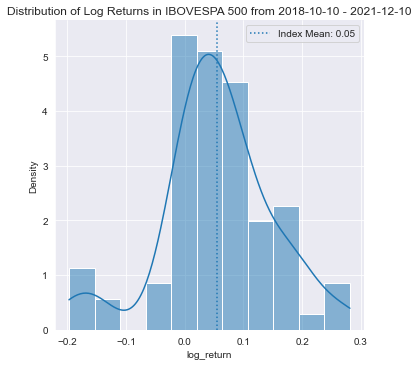

In [851]:
ibovespa_close_hist = ibovespa_return_1.T.mean(axis=1)
ibovespa_close_hist = ibovespa_close_hist*100 #Convert to percent
ibovespa_close_hist = ibovespa_close_hist.to_frame().rename(columns={0: "log_return"})

print(ibovespa_close_hist.shape)
print(ibovespa_close_hist.isnull().values.any())
plot_log_return(ibovespa_close_hist, start_date, end_date)

Cumulative log returns for the whole market

In [852]:
# Let's look at the cumulative log returns for the whole market

fig = go.Figure()

fig.add_trace(go.Scatter(x=ibovespa_return_1.index, y=ibovespa_return_1.mean(axis=1).cumsum(), name='close',
                         line=dict(color='green', width=1)))


fig.update_layout(title='Returns of iBOVESPA Index over Time Period of Study',
                  xaxis_title='Date',
                  yaxis_title='Stock Price')

fig.show()


### Feature Selection and Modeling

This section will be split into our two major modeling tasks: asset price modeling and modeling of returns. For each, we will perform feature engineering, then compare the efficacy of imputation techniques, train machine learning algorithms, and then interpret our modeling results.

#### Modeling Asset Price

The purpose of this task is to model the prices of the securities using the fundamental data related to the companies, in order to perform a pseudo-fundamental analysis of intrinsic value to develop a value investing-style trading strategy based on the residuals of our model, which represent margin of safety, or in other words, how over or under valued a given security is compared to what the model estimates its value to be.

The hypothesis is that the residuals will be correlated to the returns of the securities over the six month period since the data were scraped, as overvalued stocks would see their prices move down as the market adjusts toward their true value, and undervalued stocks would move up.

#### Feature Selection

Using features which contain information about the current price of the securities will cause target leakage, and undermine our goal of estimating intrinsic value.

The first step is to remove all features which are directly related to price, such as anything to do with periodic high/low, percent above/below these marks, and any open/close/last/bid/ask related features.

In [853]:
# # Fundamentals Analysis Dataframe -- YAHOO
# df_FA_arr = []
# df_FA = pd.DataFrame()
# for ticker in ibovespa_close.columns.values:
#     ticker = ticker.split(".")[0]

#     try:
#         # Dataframe for Quarterly Cashflow
#         df_quarterly_cashflow = pd.read_csv(
#             './data/FA/{}/quarterly_cashflow.csv'.format(ticker))
#         df_quarterly_cashflow.rename(columns={"Unnamed: 0": ""}, inplace=True)
#         df_quarterly_cashflow.set_index("", inplace=True)
#         df_quarterly_cashflow = df_quarterly_cashflow.T

#         # Dataframe for Quarterly Financials
#         df_quarterly_financials = pd.read_csv(
#             './data/FA/{}/quarterly_financials.csv'.format(ticker))
#         df_quarterly_financials.rename(
#             columns={"Unnamed: 0": ""}, inplace=True)
#         df_quarterly_financials.set_index("", inplace=True)
#         df_quarterly_financials = df_quarterly_financials.T

#         # Join Quarterly Cashflow and Quarterly Financials Dataframes
#         df_join = df_quarterly_cashflow.join(
#             df_quarterly_financials, lsuffix='_cashflow', rsuffix='_financials')
#         df_join.drop(["Net Income_cashflow"], axis=1, inplace=True)
#         df_join.rename(
#             columns={"Net Income_financials": "Net Income"}, inplace=True)
#         df_join

#         df = pd.DataFrame()
#         df = df.append(df_join.iloc[0])
#         df.reset_index(inplace=True)
#         df.rename(columns={"index": "Date"}, inplace=True)
#         df["ticker"] = ticker + ".SA"
#         df.set_index("ticker", inplace=True)

#         df_FA_arr.append(df)
#     except:
#         print('An error has occurred in Ticker: {}'.format(ticker))

# df_FA = pd.concat(df_FA_arr)
# df_FA.drop(columns=["Date"], inplace=True)
# print(df_FA.shape)


In [854]:
# Fundamentals Analysis Dataframe -- Fundamentus
import re
df_FA_arr = []
df_FA = pd.DataFrame()
path = os.getcwd()
for ticker in ibovespa_close.columns.values:
    ticker = ticker.split(".")[0]

    try:
        df_indicadores_fundamentalistas = pd.read_csv(
            path + "/data/FA/" + ticker.split(".")[0] + "/" + "indicadores_fundamentalistas.csv")
        df_indicadores_fundamentalistas.reset_index(inplace=True)
        df_indicadores_fundamentalistas.drop(
            columns=["Unnamed: 0", "index"], inplace=True)

        # df_dados_gerais = pd.read_csv(
        #     path + "/data/FA/" + ticker.split(".")[0] + "/" + "dados_gerais.csv")
        # df_dados_gerais.reset_index(inplace=True)
        # df_dados_gerais.drop(columns=["Unnamed: 0", "index"], inplace=True)

        # df_cotacao = pd.read_csv(
        #     path + "/data/FA/" + ticker.split(".")[0] + "/" + "cotacao.csv")
        # df_cotacao.reset_index(inplace=True)
        # df_cotacao.drop(columns=["Unnamed: 0", "index"], inplace=True)

        # df_balanco_patrimonial = pd.read_csv(
        #     path + "/data/FA/" + ticker.split(".")[0] + "/" + "balanco_patrimonial.csv")
        # df_balanco_patrimonial.reset_index(inplace=True)
        # df_balanco_patrimonial.drop(
        #     columns=["Unnamed: 0", "index"], inplace=True)

        # df_demonstrativos_result_12_meses = pd.read_csv(
        #     path + "/data/FA/" + ticker.split(".")[0] + "/" + "demonstrativos_result_12_meses.csv")
        # df_demonstrativos_result_12_meses.reset_index(inplace=True)
        # df_demonstrativos_result_12_meses.drop(
        #     columns=["Unnamed: 0", "index"], inplace=True)

        # df_demonstrativos_result_3_meses = pd.read_csv(
        #     path + "/data/FA/" + ticker.split(".")[0] + "/" + "demonstrativos_result_3_meses.csv")
        # df_demonstrativos_result_3_meses.reset_index(inplace=True)
        # df_demonstrativos_result_3_meses.drop(
        #     columns=["Unnamed: 0", "index"], inplace=True)

        # df_join = df_dados_gerais.join(df_cotacao)
        # df_join = df_join.join(df_indicadores_fundamentalistas)
        # df_join = df_join.join(df_balanco_patrimonial)
        # df_demonstrativos_result = df_demonstrativos_result_3_meses.join(
        #     df_demonstrativos_result_12_meses, lsuffix="_3_meses", rsuffix="_12_meses")
        # df_join = df_join.join(df_demonstrativos_result)
        df_join = df_indicadores_fundamentalistas

        df = pd.DataFrame()
        df = df.append(df_join.iloc[0])
        df["ticker"] = ticker + ".SA"
        df.set_index("ticker", inplace=True)

        df_FA_arr.append(df)
    except:
        print('An error has occurred in Ticker: {}'.format(ticker))

df_FA = pd.concat(df_FA_arr)

df_FA = df_FA.astype(str)

# Remove Percentage Sign (%)
for col in df_FA.columns:
    if df_FA[col].astype(str).str.contains("%").any():
        df_FA[col] = df_FA[col].str.replace(',', '.')
        df_FA[col] = df_FA[col].str.replace('%', '')

df_FA = df_FA.apply(pd.to_numeric, errors='coerce')
df_FA = df_FA.replace({0: np.nan})


Let's drop columns that are not number for now. In future, it may be a good ideia to replace the names by numbers to see if the sector or subsector does influence in the company's results.

Other columns that may affect our model to predict stock pricing will also be removed.

In [855]:
print(df_FA.shape)
df_FA


(81, 22)


,P/L,P/VP,P/EBIT,PSR,P/Ativos,P/Cap. Giro,P/Ativ Circ Liq,Div. Yield,EV / EBITDA,EV / EBIT,Cres. Rec (5a),LPA,VPA,Marg. Bruta,Marg. EBIT,Marg. Líquida,EBIT / Ativo,ROIC,ROE,Liquidez Corr,Div Br/ Patrim,Giro Ativos
ticker,,,,,,,,,,,,,,,,,,,,,,
ABEV3.SA,15.99,2.92,16.22,3.65,1.88,35.75,-28.90,3.0,11.43,15.13,9.9,1.01,5.51,51.9,22.5,23.4,11.6,16.1,18.3,1.23,0.03,0.51
ALPA4.SA,52.37,7.06,28.54,5.81,4.41,14.74,21.97,0.7,23.25,27.73,-0.1,0.76,5.67,53.4,20.4,11.1,15.5,20.9,13.5,2.13,0.07,0.76
AMER3.SA,385.85,1.72,42.20,1.59,0.62,2.65,-8.81,NaN,18.99,47.94,19.8,0.08,17.34,29.8,3.8,0.4,1.5,2.5,0.4,1.70,0.85,0.39
AZUL4.SA,-2.07,-0.48,-93.13,1.07,0.48,-1.83,-0.30,NaN,11.49,-166.73,-6.8,-11.96,-51.86,9.8,-1.2,-51.9,-0.5,-0.7,23.1,0.59,-0.58,0.45
B3SA3.SA,15.63,3.27,11.34,7.16,1.35,7.42,-11.16,6.8,8.41,9.80,33.8,0.77,3.69,90.7,63.2,45.8,11.9,21.2,20.9,1.64,0.62,0.19
BBAS3.SA,5.37,0.68,NaN,NaN,NaN,NaN,NaN,6.8,NaN,NaN,2.2,6.07,47.72,NaN,NaN,NaN,NaN,NaN,12.7,NaN,NaN,NaN
BBDC3.SA,7.13,1.17,NaN,NaN,NaN,NaN,NaN,5.9,NaN,NaN,24.1,2.49,15.19,NaN,NaN,NaN,NaN,NaN,16.4,NaN,NaN,NaN
BBDC4.SA,8.40,1.38,NaN,NaN,NaN,NaN,NaN,5.5,NaN,NaN,24.1,2.49,15.19,NaN,NaN,NaN,NaN,NaN,16.4,NaN,NaN,NaN
BBSE3.SA,11.71,5.45,9.16,NaN,3.66,NaN,NaN,4.7,NaN,NaN,NaN,1.81,3.89,NaN,NaN,NaN,40.0,NaN,46.6,NaN,NaN,NaN


In [856]:
df_FA.info()

<class 'pandas.core.frame.DataFrame'>
Index: 81 entries, ABEV3.SA to YDUQ3.SA
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   P/L              81 non-null     float64
 1   P/VP             81 non-null     float64
 2   P/EBIT           73 non-null     float64
 3   PSR              71 non-null     float64
 4   P/Ativos         73 non-null     float64
 5   P/Cap. Giro      71 non-null     float64
 6   P/Ativ Circ Liq  71 non-null     float64
 7   Div. Yield       65 non-null     float64
 8   EV / EBITDA      71 non-null     float64
 9   EV / EBIT        71 non-null     float64
 10  Cres. Rec (5a)   79 non-null     float64
 11  LPA              81 non-null     float64
 12  VPA              81 non-null     float64
 13  Marg. Bruta      71 non-null     float64
 14  Marg. EBIT       71 non-null     float64
 15  Marg. Líquida    70 non-null     float64
 16  EBIT / Ativo     73 non-null     float64
 17  ROIC      

Since we want to get meaningful insights from the feature importances of the models that we train, we need to now deal with multicollinearity among the features. To start this process, we need to generate a heatmap to visualize the correlation matrix of all of the features. We can do this with a combination of the pandas .corr method and seaborn’s heatmap.

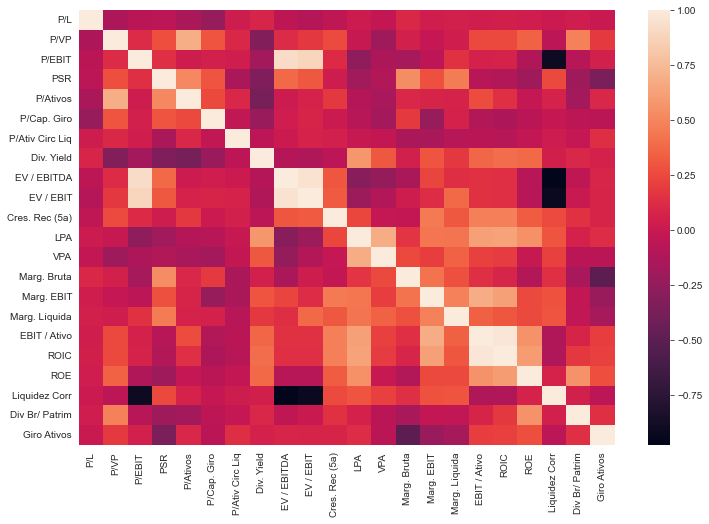

In [857]:
# Generate correlation matrix
corr = df_FA.corr()

# Make figure and generate heatmap
plt.figure(figsize=(12,8))
sns.heatmap(corr);

In [858]:
df_FA.drop(columns=["EV / EBIT", "P/EBIT", "EBIT / Ativo"], inplace=True)
df_FA.info()

<class 'pandas.core.frame.DataFrame'>
Index: 81 entries, ABEV3.SA to YDUQ3.SA
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   P/L              81 non-null     float64
 1   P/VP             81 non-null     float64
 2   PSR              71 non-null     float64
 3   P/Ativos         73 non-null     float64
 4   P/Cap. Giro      71 non-null     float64
 5   P/Ativ Circ Liq  71 non-null     float64
 6   Div. Yield       65 non-null     float64
 7   EV / EBITDA      71 non-null     float64
 8   Cres. Rec (5a)   79 non-null     float64
 9   LPA              81 non-null     float64
 10  VPA              81 non-null     float64
 11  Marg. Bruta      71 non-null     float64
 12  Marg. EBIT       71 non-null     float64
 13  Marg. Líquida    70 non-null     float64
 14  ROIC             71 non-null     float64
 15  ROE              81 non-null     float64
 16  Liquidez Corr    71 non-null     float64
 17  Div Br/ Pa

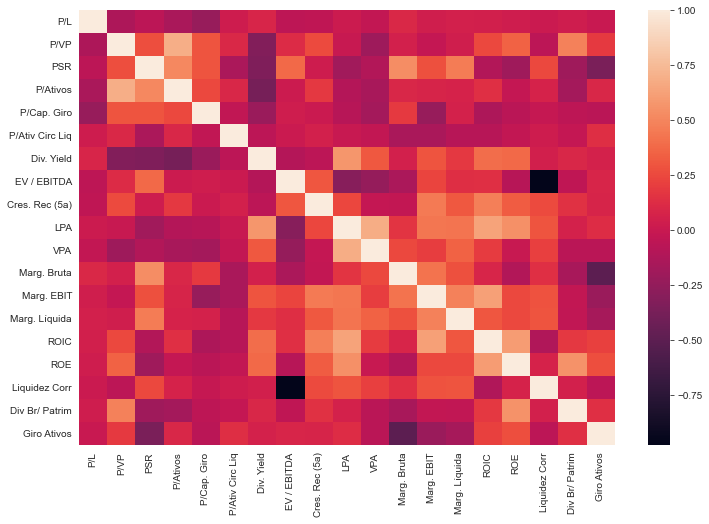

In [859]:
# Generate correlation matrix
corr = df_FA.corr()

# Make figure and generate heatmap
plt.figure(figsize=(12,8))
sns.heatmap(corr);

### Imputing Missing Data

Scikit-learn offers a variety of effective methods of imputation between their <b>SimpleImputer</b>, <b>KNNImputer</b>, and <b>IterativeImputer</b> classes.

- The SimpleImputer can utilize multiple strategies to fill nans: using the mean, median, mode, or a constant value. 

- The KNNImputer utilizes K Nearest Neighbor modeling to estimate the missing values using the other data columns as predictors. 

- The IterativeImputer is experimental, and allows for any estimator to be passed into it, which it uses to estimate missing values in a round-robin fashion.



> Many popular predictive models such as support vector machines, the glmnet, and neural networks, cannot tolerate any amount of missing values.

— Page 195, Feature Engineering and Selection, 2019.

> The simplest approach for dealing with missing values is to remove entire predictor(s) and/or sample(s) that contain missing values.



— Page 196, Feature Engineering and Selection, 2019.

> missing data can be imputed. In this case, we can use information in the training set predictors to, in essence, estimate the values of other predictors.

— Page 42, Applied Predictive Modeling, 2013.

There are many options we could consider when replacing a missing value, for example:

    - A constant value that has meaning within the domain, such as 0, distinct from all other values.
    - A value from another randomly selected record.
    - A mean, median or mode value for the column.
    - A value estimated by another predictive model.


The scikit-learn library provides the SimpleImputer pre-processing class that can be used to replace missing values.

It is a flexible class that allows you to specify the value to replace (it can be something other than NaN) and the technique used to replace it (such as mean, median, or mode). The SimpleImputer class operates directly on the NumPy array instead of the DataFrame.

First, we need to ensure that our missing values are in a consistent format, so that the imputation algorithms can locate them. We need to check for infs in the data

In [860]:
print(np.inf in df_FA.values or -np.inf in df_FA.values)

for col in df_FA.columns:
    if np.inf in df_FA[col].values or -np.inf in df_FA[col].values:
        print(col)

False


In [861]:
scaler = StandardScaler()
X = df_FA.loc[df_FA.index.isin(ibovespa_close_hist.index)]
y = ibovespa_close_hist.loc[ibovespa_close_hist.index.isin(df_FA.index)]["log_return"]

print(X.shape)
print(y.shape)

y.head()

(81, 19)
(81,)


ABEV3.SA    0.000536
ALPA4.SA    0.170259
AMER3.SA   -0.009093
AZUL4.SA   -0.001749
B3SA3.SA    0.066251
Name: log_return, dtype: float64

In [862]:
X.head()

,P/L,P/VP,PSR,P/Ativos,P/Cap. Giro,P/Ativ Circ Liq,Div. Yield,EV / EBITDA,Cres. Rec (5a),LPA,VPA,Marg. Bruta,Marg. EBIT,Marg. Líquida,ROIC,ROE,Liquidez Corr,Div Br/ Patrim,Giro Ativos
ticker,,,,,,,,,,,,,,,,,,,
ABEV3.SA,15.99,2.92,3.65,1.88,35.75,-28.90,3.0,11.43,9.9,1.01,5.51,51.9,22.5,23.4,16.1,18.3,1.23,0.03,0.51
ALPA4.SA,52.37,7.06,5.81,4.41,14.74,21.97,0.7,23.25,-0.1,0.76,5.67,53.4,20.4,11.1,20.9,13.5,2.13,0.07,0.76
AMER3.SA,385.85,1.72,1.59,0.62,2.65,-8.81,NaN,18.99,19.8,0.08,17.34,29.8,3.8,0.4,2.5,0.4,1.70,0.85,0.39
AZUL4.SA,-2.07,-0.48,1.07,0.48,-1.83,-0.30,NaN,11.49,-6.8,-11.96,-51.86,9.8,-1.2,-51.9,-0.7,23.1,0.59,-0.58,0.45
B3SA3.SA,15.63,3.27,7.16,1.35,7.42,-11.16,6.8,8.41,33.8,0.77,3.69,90.7,63.2,45.8,21.2,20.9,1.64,0.62,0.19


In [863]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

In [864]:
print(y.isnull().values.any())
print(y.isnull().sum().sum())

print(X.isnull().values.any())
print(X.isnull().sum().sum())

False
0
True
139


I will start by making two target categorical variables. The first will be a binary category representing securities with returns of above or below zero, with 1 representing gainers and 0 representing losers. 

A possible issue with training a classifier this way and trying to deploy it on future data is that different time periods will see the market trending in different directions, meaning that the average return for securities within the SP500 index will be positive or negative, given different time periods of study. Since the market has been trending upward in the past 6 months, and the average return is positive, most of the securities will fall into the gainer category due in large part to the overall movement of the market during this time, obfuscating the effect of the independent variables on the performance of their related securities. 

An algorithm trained on a time period of overall market growth may fail to be useful if deployed on a later time period when the market trended differently. For this reason, it is probably a better idea to subtract the average return of the SP500 index from the returns of each of the securities, then classify them as positive or negative, reflecting whether they performed better or worse than the market in general. 

This method of classification would logically be more robust to different market conditions, since the differences in performance would be more closely related to the fundamentals of the companies, having removed the influence of the overall market trend. Keeping this in mind, I will train algorithms on both targets, in case any additional insights may be obtained.

In [868]:
returns_classes = ibovespa_close_hist.loc[ibovespa_close_hist.index.isin(
    df_FA.index)].copy()

# class1
returns_classes.loc[returns_classes.log_return > 0, 'class1'] = 1
returns_classes.loc[returns_classes.log_return <= 0, 'class1'] = 0

# class2
returns_classes.loc[returns_classes.log_return -
                    returns_classes.log_return.mean() > 0, 'class2'] = 1
returns_classes.loc[returns_classes.log_return -
                    returns_classes.log_return.mean() <= 0, 'class2'] = 0

print(returns_classes.shape)                    
returns_classes.head()


(81, 3)


,log_return,class1,class2
ABEV3.SA,0.000536,1.0,0.0
ALPA4.SA,0.170259,1.0,1.0
AMER3.SA,-0.009093,0.0,0.0
AZUL4.SA,-0.001749,0.0,0.0
B3SA3.SA,0.066251,1.0,1.0


#### Per-class feature histograms on our df_FA dataset

This gives us some idea of how each feature is distributed across the two classes, and allows us to venture a guess as to which features are better at distinguishing class1 and class2 samples

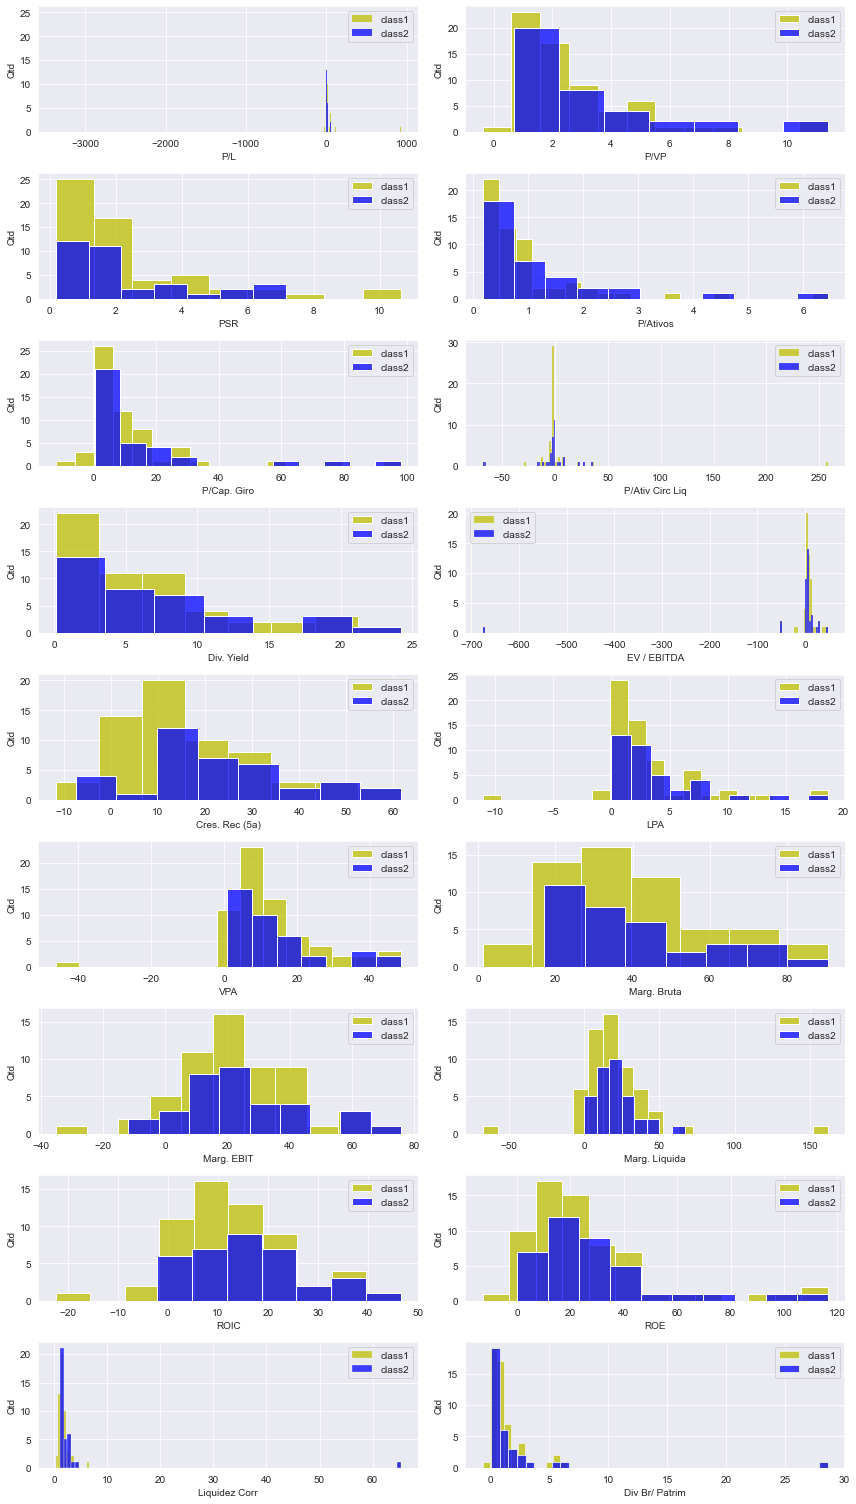

In [866]:
fig, ax = plt.subplots(nrows=9, ncols=2, figsize=(12, 21))
columns = X.columns.tolist()
for column, ax in zip( X.columns.tolist(), ax.flatten()):    
    class1 = returns_classes.loc[returns_classes["class1"] == 1]["class1"]
    class2 = returns_classes.loc[returns_classes["class2"] == 1]["class2"]

    x1 = X.loc[X.index.isin(class1.index)][column].tolist()
    x2 = X.loc[X.index.isin(class2.index)][column].tolist()

    sns.histplot(data=class1, x=x1, ax=ax, color="y", label='class1')
    sns.histplot(data=class2, x=x2, ax=ax, color="b", label='class2')

    ax.set_xlabel(column)
    ax.set_ylabel('Qtd')
    ax.legend()

plt.tight_layout()
plt.show()


Let's start by testing some simple imputer methods, before using some complex coding

In [870]:
def evaluate_score(regressor, imputer):

    # define the modeling pipeline
    pipeline = Pipeline(steps=[('i', imputer), ('m', regressor)])

    # evaluate the model
    scores = cross_val_score(pipeline, X, y, scoring='r2', cv=5, n_jobs=-1)

    # report the mean performance
    # print('Accuracy: %.3f' % result.mean())
    print('Mean Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))


imputer = SimpleImputer(missing_values=np.nan,
                        strategy='constant', fill_value=0)

imputed = imputer.fit_transform(X)
print(len(imputed))
X_imputed = pd.DataFrame(imputed, columns=X.columns, index=X.index)


print(X.isnull().values.any())
print(X.isnull().sum().sum())

print(X_imputed.isnull().values.any())
print(X_imputed.isnull().sum().sum())

X_imputed.head()


81
True
139
False
0


,P/L,P/VP,PSR,P/Ativos,P/Cap. Giro,P/Ativ Circ Liq,Div. Yield,EV / EBITDA,Cres. Rec (5a),LPA,VPA,Marg. Bruta,Marg. EBIT,Marg. Líquida,ROIC,ROE,Liquidez Corr,Div Br/ Patrim,Giro Ativos
ticker,,,,,,,,,,,,,,,,,,,
ABEV3.SA,15.99,2.92,3.65,1.88,35.75,-28.90,3.0,11.43,9.9,1.01,5.51,51.9,22.5,23.4,16.1,18.3,1.23,0.03,0.51
ALPA4.SA,52.37,7.06,5.81,4.41,14.74,21.97,0.7,23.25,-0.1,0.76,5.67,53.4,20.4,11.1,20.9,13.5,2.13,0.07,0.76
AMER3.SA,385.85,1.72,1.59,0.62,2.65,-8.81,0.0,18.99,19.8,0.08,17.34,29.8,3.8,0.4,2.5,0.4,1.70,0.85,0.39
AZUL4.SA,-2.07,-0.48,1.07,0.48,-1.83,-0.30,0.0,11.49,-6.8,-11.96,-51.86,9.8,-1.2,-51.9,-0.7,23.1,0.59,-0.58,0.45
B3SA3.SA,15.63,3.27,7.16,1.35,7.42,-11.16,6.8,8.41,33.8,0.77,3.69,90.7,63.2,45.8,21.2,20.9,1.64,0.62,0.19


In [871]:


X_train_imputed, X_test_imputed, y_train_imputed, y_test_imputed = train_test_split(
    X_imputed, y)

scaled_X_imputed = scaler.fit_transform(X_imputed)    
scaled_X_train_imputed = scaler.fit_transform(X_train_imputed)
scaled_X_test_imputed = scaler.transform(X_test_imputed)

KNeighborsRegressor

In [689]:
reg = KNeighborsRegressor(n_neighbors=3)
reg.fit(X_train_imputed, y_train_imputed)

print("Test set predictions:\n", reg.predict(X_test_imputed))
print("Test set R^2: {:.2f}".format(reg.score(X_test_imputed, y_test_imputed)))

Test set predictions:
 [ 0.0366709   0.10858699  0.06901213  0.11402437  0.06126121  0.0866459
  0.03114421  0.05485086 -0.05426797 -0.04730332  0.11514718  0.04124112
  0.10819046  0.07088253  0.08997383  0.02295333  0.04864552  0.08908136
  0.05159103  0.07172116  0.0245808 ]
Test set R^2: 0.01


LinearRegression

In [690]:
lr = LinearRegression().fit(X_train_imputed, y_train_imputed)

print("Training set score: {:.2f}".format(lr.score(X_train_imputed, y_train_imputed)))
print("Test set score: {:.2f}".format(lr.score(X_test_imputed, y_test_imputed)))

Training set score: 0.55
Test set score: -10.97


Ridge Regression

In [691]:
ridge = Ridge().fit(X_train_imputed, y_train_imputed)

print("Training set score: {:.2f}".format(ridge.score(X_train_imputed, y_train_imputed)))
print("Test set score: {:.2f}".format(ridge.score(X_test_imputed, y_test_imputed)))
evaluate_score(ridge, imputer)

Training set score: 0.55
Test set score: -10.59
Mean Accuracy: -2.924 (5.687)


In [692]:
ridge = Ridge(alpha=0.1).fit(X_train_imputed, y_train_imputed)

print("Training set score: {:.2f}".format(ridge.score(X_train_imputed, y_train_imputed)))
print("Test set score: {:.2f}".format(ridge.score(X_test_imputed, y_test_imputed)))

Training set score: 0.55
Test set score: -10.93


In [693]:
ridge = Ridge(alpha=250).fit(X_train_imputed, y_train_imputed)

print("Training set score: {:.2f}".format(ridge.score(X_train_imputed, y_train_imputed)))
print("Test set score: {:.2f}".format(ridge.score(X_test_imputed, y_test_imputed)))

Training set score: 0.50
Test set score: -3.83


Lasso Regression

In [694]:
lasso = Lasso().fit(X_train_imputed, y_train_imputed)

print("Training set score: {:.2f}".format(
    lasso.score(X_train_imputed, y_train_imputed)))
print("Test set score: {:.2f}".format(
    lasso.score(X_test_imputed, y_test_imputed)))
print("Number of features used:", np.sum(lasso.coef_ != 0))


Training set score: 0.00
Test set score: -0.18
Number of features used: 1


In [695]:
lasso = Lasso(alpha=0.01, max_iter=100000).fit(X_train_imputed, y_train_imputed)

print("Training set score: {:.2f}".format(
    lasso.score(X_train_imputed, y_train_imputed)))
print("Test set score: {:.2f}".format(
    lasso.score(X_test_imputed, y_test_imputed)))
print("Number of features used:", np.sum(lasso.coef_ != 0))


Training set score: 0.51
Test set score: -3.86
Number of features used: 15


DecisionTrees

In [697]:
tree = DecisionTreeRegressor(max_depth=2).fit(X_train_imputed, y_train_imputed)
print("Training set score: {:.2f}".format(
    tree.score(X_train_imputed, y_train_imputed)))
print("Test set score: {:.2f}".format(
    tree.score(X_test_imputed, y_test_imputed)))
    
evaluate_score(tree, imputer)

Training set score: 0.57
Test set score: 0.54
Mean Accuracy: -0.082 (1.132)


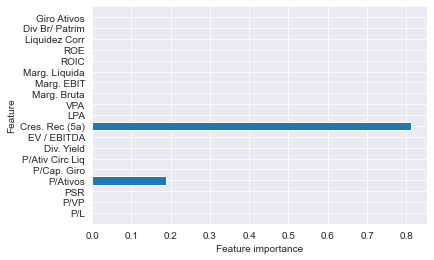

In [698]:
def plot_feature_importances(model, X):
    n_features = len(X.columns.tolist())
    plt.barh(np.arange(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), X.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)

plot_feature_importances(tree, X)

Random Forests

In [700]:
forest = RandomForestRegressor(n_estimators=100, random_state=0)
forest.fit(X_train_imputed, y_train_imputed)

print("Accuracy on training set: {:.3f}".format(
    forest.score(X_train_imputed, y_train_imputed)))
print("Accuracy on test set: {:.3f}".format(
    forest.score(X_test_imputed, y_test_imputed)))

evaluate_score(forest, imputer)

Accuracy on training set: 0.917
Accuracy on test set: 0.408
Mean Accuracy: 0.197 (0.268)


Accuracy on training set: 0.917
Accuracy on test set: 0.408


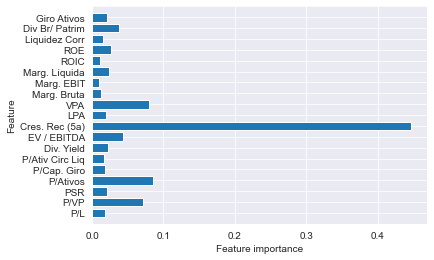

In [701]:
forest = RandomForestRegressor(random_state=0)
forest.fit(X_train_imputed, y_train_imputed)

print("Accuracy on training set: {:.3f}".format(
    forest.score(X_train_imputed, y_train_imputed)))
print("Accuracy on test set: {:.3f}".format(
    forest.score(X_test_imputed, y_test_imputed)))

plot_feature_importances(forest, X)

Gradient Boosted Regression Trees

In [702]:
gbrt = GradientBoostingRegressor(random_state=0)
gbrt.fit(X_train_imputed, y_train_imputed)

print("Accuracy on training set: {:.3f}".format(
    gbrt.score(X_train_imputed, y_train_imputed)))
print("Accuracy on test set: {:.3f}".format(
    gbrt.score(X_test_imputed, y_test_imputed)))

Accuracy on training set: 0.999
Accuracy on test set: 0.372


In [703]:
gbrt = GradientBoostingRegressor(random_state=0, learning_rate=0.01)
gbrt.fit(X_train_imputed, y_train_imputed)

print("Accuracy on training set: {:.3f}".format(
    gbrt.score(X_train_imputed, y_train_imputed)))
print("Accuracy on test set: {:.3f}".format(
    gbrt.score(X_test_imputed, y_test_imputed)))


Accuracy on training set: 0.723
Accuracy on test set: 0.334


Accuracy on training set: 0.793
Accuracy on test set: 0.174


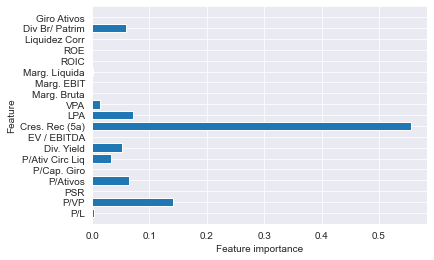

In [704]:
gbrt = GradientBoostingRegressor(random_state=0, max_depth=1)
gbrt.fit(X_train_imputed, y_train_imputed)

print("Accuracy on training set: {:.3f}".format(
    gbrt.score(X_train_imputed, y_train_imputed)))
print("Accuracy on test set: {:.3f}".format(
    gbrt.score(X_test_imputed, y_test_imputed)))

plot_feature_importances(gbrt, X)


Neural Networks

In [754]:
from sklearn.metrics import r2_score

mlp = MLPRegressor(random_state=0, max_iter=2000, alpha=1, hidden_layer_sizes=[10, 10])
mlp.fit(scaled_X_train_imputed, y_train_imputed)

print("Accuracy on training set: {:.3f}".format(
    mlp.score(scaled_X_train_imputed, y_train_imputed)))
print("Accuracy on test set: {:.3f}".format(
    mlp.score(scaled_X_test_imputed, y_test_imputed)))


Accuracy on training set: 0.407
Accuracy on test set: 0.308


In [654]:
N_SPLITS = 5

# Now for some helper functions to make it easier to compare imputation methods
# Note that these are modified versions of the code found in the scikit learn docs
def get_scores_for_imputer(imputer, X_missing, y_missing, regressor, scoring, scale=True):
    if scale:
        steps = [('scaler', StandardScaler()), 
                 ('imputer', imputer), 
                 ('regressor', regressor)]
    else:
        steps = [('imputer', imputer), 
                 ('regressor', regressor)]
        
    estimator = Pipeline(steps=steps)
    impute_scores = cross_val_score(estimator, X_missing, y_missing,
                                    scoring=scoring,
                                    cv=N_SPLITS)
    return impute_scores

def get_impute_zero_score(X_missing, y_missing, regressor, scoring):

    imputer = SimpleImputer(missing_values=np.nan, add_indicator=True,
                            strategy='constant', fill_value=0)
                            
    zero_impute_scores = get_scores_for_imputer(imputer, 
                                                X_missing, 
                                                y_missing, 
                                                regressor, 
                                                scoring)
    return zero_impute_scores.mean(), zero_impute_scores.std()

def get_impute_knn_score(X_missing, y_missing, regressor, scoring, n_neighbors=5):
    imputer = KNNImputer(missing_values=np.nan, 
                         add_indicator=True, 
                         n_neighbors=n_neighbors,
                         weights='distance')
    knn_impute_scores = get_scores_for_imputer(imputer, 
                                               X_missing, 
                                               y_missing, 
                                               regressor, 
                                               scoring)
    return knn_impute_scores.mean(), knn_impute_scores.std()

def get_impute_mean(X_missing, y_missing, regressor, scoring):
    imputer = SimpleImputer(missing_values=np.nan, strategy="mean",
                            add_indicator=True)
    mean_impute_scores = get_scores_for_imputer(imputer, 
                                                X_missing, 
                                                y_missing, 
                                                regressor, 
                                                scoring)
    return mean_impute_scores.mean(), mean_impute_scores.std()

def get_impute_iterative(X_missing, y_missing, regressor, scoring, estimator=None,
                         n_nearest_features=None, max_iter=10
                        ):
    sample_posterior = False
    if 'BayesianRidge' in str(estimator):
        sample_posterior = True
    elif estimator is None:
        n_nearest_features = 5
        sample_posterior = True
       
    imputer = IterativeImputer(estimator=estimator,
                               missing_values=np.nan, 
                               max_iter=max_iter,
                               add_indicator=True,
                               random_state=0, 
                               n_nearest_features=n_nearest_features,
                               sample_posterior=sample_posterior
                              )
    iterative_impute_scores = get_scores_for_imputer(imputer,
                                                     X_missing,
                                                     y_missing,
                                                     regressor,
                                                     scoring
                                                    )
    
    return iterative_impute_scores.mean(), iterative_impute_scores.std()


In [655]:

# Function to graph results of imputation comparisons
def graph_imputer_scores(scores, stds, labels, scoring, regressor=None, iterative=False):
    n_bars = len(scores)
    xval = np.arange(n_bars)

    if regressor is not None:
        name = str(regressor).split('(')[0]
        title_string = ' with {}'.format(name)
    else:
        title_string = ''

    x_labels = labels
    colors = ['r', 'g', 'b', 'orange', 'black']

    plt.figure(figsize=(12, 6))
    ax1 = plt.subplot(111)
    for j in xval:
        ax1.barh(j, scores[j], xerr=stds[j],
                 color=colors[j], alpha=0.6, align='center')
    if not iterative:
        ax1.set_title(
            'Imputation Techniques Comparison{}'.format(title_string))
    else:
        ax1.set_title(
            'Iterative Imputation Estimator Comparison{}'.format(title_string))
    ax1.set_xlim(left=np.min(scores*2) * 0.9,
                 right=np.max(scores*2) * 1.1)
    ax1.set_yticks(xval)
    ax1.set_xlabel(scoring)
    ax1.invert_yaxis()
    ax1.set_yticklabels(x_labels)

    return ax1

# Creating a wrapper function to keep code DRY
def compare_imputer_scores(X, y, regressor, scoring, iterative_estimators=None, max_iter=10):
    # Getting scores for these imputers
    zero_scores = get_impute_zero_score(X, y, regressor, scoring)
    mean_scores = get_impute_mean(X, y, regressor, scoring)
    knn_scores = get_impute_knn_score(X, y, regressor, scoring)
    iter_scores = get_impute_iterative(
        X, y, regressor, scoring, n_nearest_features=5)

    scores = [zero_scores[0], mean_scores[0], knn_scores[0], iter_scores[0]]
    stds = [zero_scores[1], mean_scores[1], knn_scores[1], iter_scores[1]]

    # Graphing the scores of the imputation methods above
    labels = ['Zero imputation',
              'Mean Imputation',
              'KNN Imputation',
              'Iterative Imputation']

    # Now to run through the estimators for IterativeImputer
    results = []

    if iterative_estimators:
        labels2 = []
        for estimator in iterative_estimators:
            name = str(estimator).split('(')[0]
            print('Imputing with IterativeImputer using {} estimator'.format(name))
            labels2.append(name)

            n_nearest_features = None
            if 'BayesianRidge' in str(estimator):
                n_nearest_features = 5

            results.append(get_impute_iterative(X,
                                                y,
                                                regressor,
                                                scoring,
                                                estimator,
                                                n_nearest_features=n_nearest_features,
                                                max_iter=max_iter
                                                )
                           )

        scores2 = [results[i][0] for i in range(len(results))]
        stds2 = [results[i][1] for i in range(len(results))]

    ax1 = graph_imputer_scores(scores, stds, labels, scoring, regressor)

    if iterative_estimators:
        ax2 = graph_imputer_scores(
            scores2, stds2, labels2, scoring, regressor, iterative=True)
        return ax1, ax2

    return ax1


#### Linear Regressor

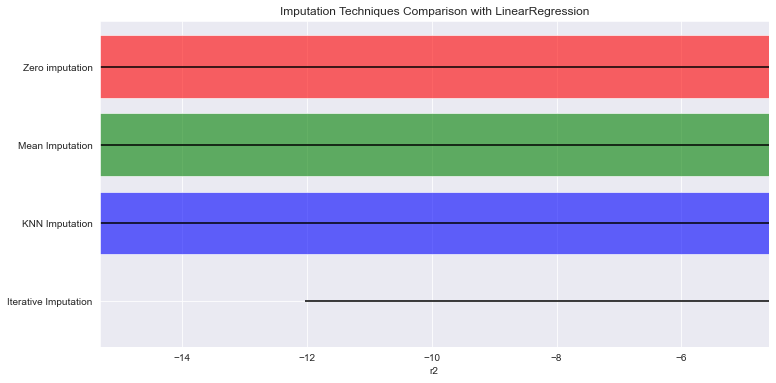

In [503]:
regressor = LinearRegression()

ax = compare_imputer_scores(X, y, regressor, scoring='r2')

#### Lasso Regressor

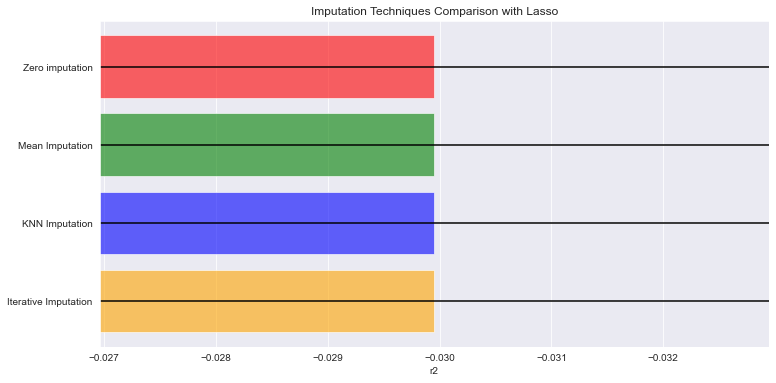

In [504]:
regressor = Lasso()
x1 = compare_imputer_scores(X, y, regressor, scoring='r2')

#### RandomForest Regressor

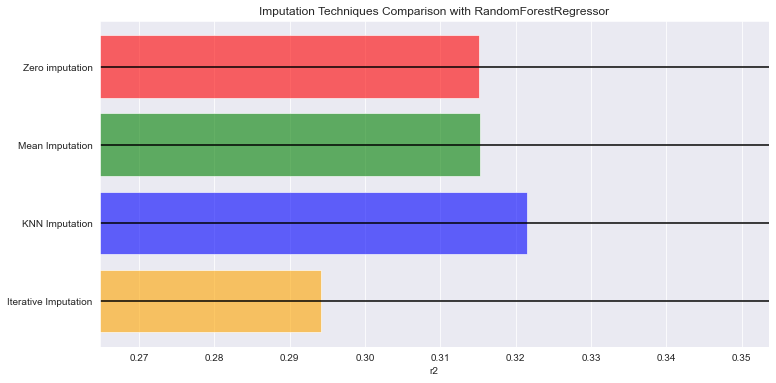

In [667]:
regressor = RandomForestRegressor(random_state=0)

ax = compare_imputer_scores(X, y, regressor, scoring='r2')

#### GradientBoost Regressor

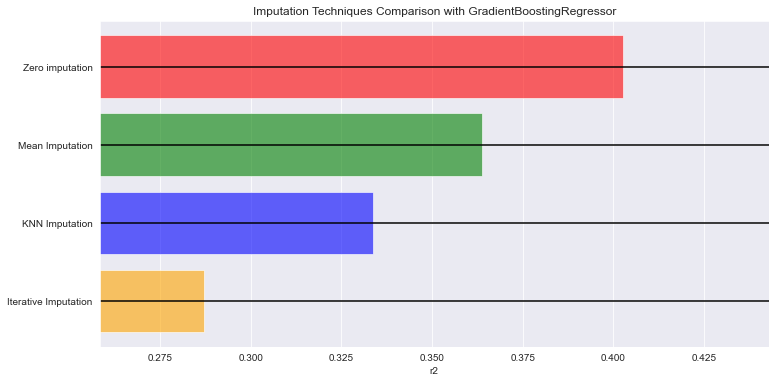

In [668]:
regressor = GradientBoostingRegressor()

ax1 = compare_imputer_scores(X, y, regressor, 'r2')

There are some options for IterativeImputer that have not been explored yet. Let's take a look

In [616]:
estimators = [
    BayesianRidge(),
    DecisionTreeRegressor(max_features='auto', random_state=0),
    RandomForestRegressor(random_state=0),
    ExtraTreesRegressor(n_estimators=10, random_state=0),
    KNeighborsRegressor(n_neighbors=15)
]

Imputing with IterativeImputer using BayesianRidge estimator
Imputing with IterativeImputer using DecisionTreeRegressor estimator


/Users/igorlimarochaazevedo/Documents/Documents_IgorsMacBookPro/UnB/TCC/MLFA/MLFA_VENV/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning:

[IterativeImputer] Early stopping criterion not reached.

/Users/igorlimarochaazevedo/Documents/Documents_IgorsMacBookPro/UnB/TCC/MLFA/MLFA_VENV/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning:

[IterativeImputer] Early stopping criterion not reached.

/Users/igorlimarochaazevedo/Documents/Documents_IgorsMacBookPro/UnB/TCC/MLFA/MLFA_VENV/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning:

[IterativeImputer] Early stopping criterion not reached.

/Users/igorlimarochaazevedo/Documents/Documents_IgorsMacBookPro/UnB/TCC/MLFA/MLFA_VENV/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning:

[IterativeImputer] Early stopping criterion not reached.



Imputing with IterativeImputer using RandomForestRegressor estimator


/Users/igorlimarochaazevedo/Documents/Documents_IgorsMacBookPro/UnB/TCC/MLFA/MLFA_VENV/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning:

[IterativeImputer] Early stopping criterion not reached.

/Users/igorlimarochaazevedo/Documents/Documents_IgorsMacBookPro/UnB/TCC/MLFA/MLFA_VENV/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning:

[IterativeImputer] Early stopping criterion not reached.

/Users/igorlimarochaazevedo/Documents/Documents_IgorsMacBookPro/UnB/TCC/MLFA/MLFA_VENV/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning:

[IterativeImputer] Early stopping criterion not reached.

/Users/igorlimarochaazevedo/Documents/Documents_IgorsMacBookPro/UnB/TCC/MLFA/MLFA_VENV/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning:

[IterativeImputer] Early stopping criterion not reached.



Imputing with IterativeImputer using ExtraTreesRegressor estimator


/Users/igorlimarochaazevedo/Documents/Documents_IgorsMacBookPro/UnB/TCC/MLFA/MLFA_VENV/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning:

[IterativeImputer] Early stopping criterion not reached.

/Users/igorlimarochaazevedo/Documents/Documents_IgorsMacBookPro/UnB/TCC/MLFA/MLFA_VENV/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning:

[IterativeImputer] Early stopping criterion not reached.

/Users/igorlimarochaazevedo/Documents/Documents_IgorsMacBookPro/UnB/TCC/MLFA/MLFA_VENV/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning:

[IterativeImputer] Early stopping criterion not reached.

/Users/igorlimarochaazevedo/Documents/Documents_IgorsMacBookPro/UnB/TCC/MLFA/MLFA_VENV/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning:

[IterativeImputer] Early stopping criterion not reached.

/Users/igorlimarochaazevedo/Documents/Documents_IgorsMacBookPro/UnB/TCC/MLFA/MLFA_VENV/l

Imputing with IterativeImputer using KNeighborsRegressor estimator


/Users/igorlimarochaazevedo/Documents/Documents_IgorsMacBookPro/UnB/TCC/MLFA/MLFA_VENV/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning:

[IterativeImputer] Early stopping criterion not reached.

/Users/igorlimarochaazevedo/Documents/Documents_IgorsMacBookPro/UnB/TCC/MLFA/MLFA_VENV/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning:

[IterativeImputer] Early stopping criterion not reached.



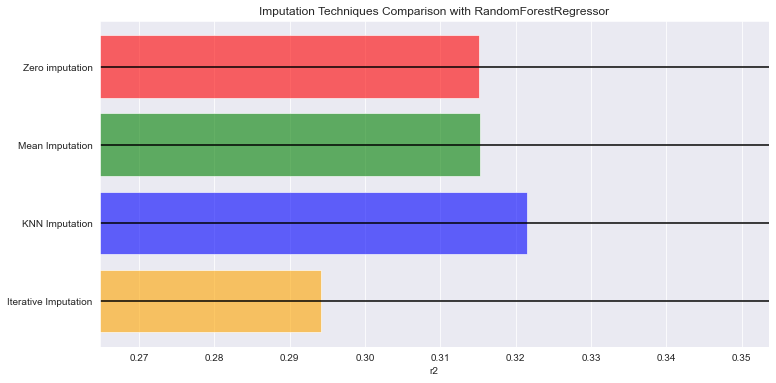

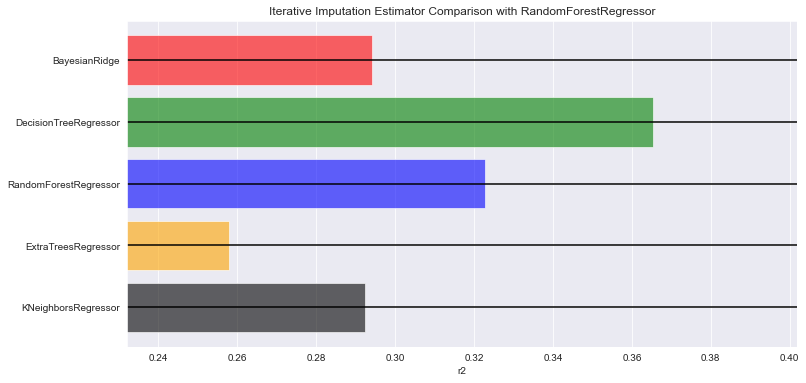

In [617]:
ax1, ax2 = compare_imputer_scores(X, 
                                  y,
                                  regressor, 
                                  scoring='r2', 
                                  iterative_estimators=estimators)

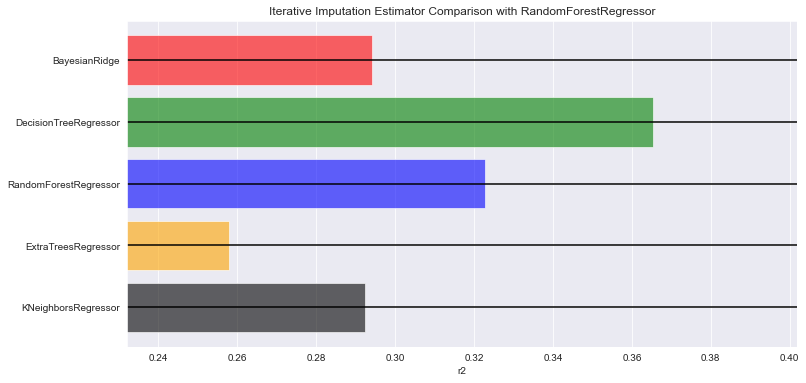

In [618]:
ax2.figure

In [619]:
estimators = [
    BayesianRidge(),
    DecisionTreeRegressor(max_features='auto', random_state=123),
    ExtraTreesRegressor(n_estimators=10, max_features='sqrt', random_state=123),
    KNeighborsRegressor(n_neighbors=15)
]

Imputing with IterativeImputer using BayesianRidge estimator
Imputing with IterativeImputer using DecisionTreeRegressor estimator


/Users/igorlimarochaazevedo/Documents/Documents_IgorsMacBookPro/UnB/TCC/MLFA/MLFA_VENV/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning:

[IterativeImputer] Early stopping criterion not reached.

/Users/igorlimarochaazevedo/Documents/Documents_IgorsMacBookPro/UnB/TCC/MLFA/MLFA_VENV/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning:

[IterativeImputer] Early stopping criterion not reached.

/Users/igorlimarochaazevedo/Documents/Documents_IgorsMacBookPro/UnB/TCC/MLFA/MLFA_VENV/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning:

[IterativeImputer] Early stopping criterion not reached.

/Users/igorlimarochaazevedo/Documents/Documents_IgorsMacBookPro/UnB/TCC/MLFA/MLFA_VENV/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning:

[IterativeImputer] Early stopping criterion not reached.



Imputing with IterativeImputer using ExtraTreesRegressor estimator


/Users/igorlimarochaazevedo/Documents/Documents_IgorsMacBookPro/UnB/TCC/MLFA/MLFA_VENV/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning:

[IterativeImputer] Early stopping criterion not reached.

/Users/igorlimarochaazevedo/Documents/Documents_IgorsMacBookPro/UnB/TCC/MLFA/MLFA_VENV/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning:

[IterativeImputer] Early stopping criterion not reached.

/Users/igorlimarochaazevedo/Documents/Documents_IgorsMacBookPro/UnB/TCC/MLFA/MLFA_VENV/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning:

[IterativeImputer] Early stopping criterion not reached.

/Users/igorlimarochaazevedo/Documents/Documents_IgorsMacBookPro/UnB/TCC/MLFA/MLFA_VENV/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning:

[IterativeImputer] Early stopping criterion not reached.

/Users/igorlimarochaazevedo/Documents/Documents_IgorsMacBookPro/UnB/TCC/MLFA/MLFA_VENV/l

Imputing with IterativeImputer using KNeighborsRegressor estimator


/Users/igorlimarochaazevedo/Documents/Documents_IgorsMacBookPro/UnB/TCC/MLFA/MLFA_VENV/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning:

[IterativeImputer] Early stopping criterion not reached.

/Users/igorlimarochaazevedo/Documents/Documents_IgorsMacBookPro/UnB/TCC/MLFA/MLFA_VENV/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning:

[IterativeImputer] Early stopping criterion not reached.



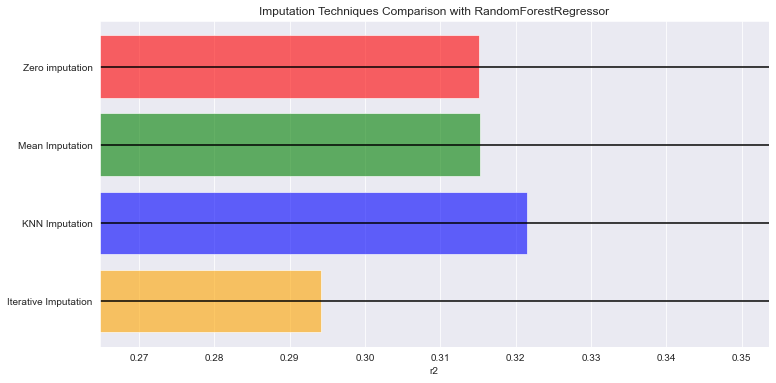

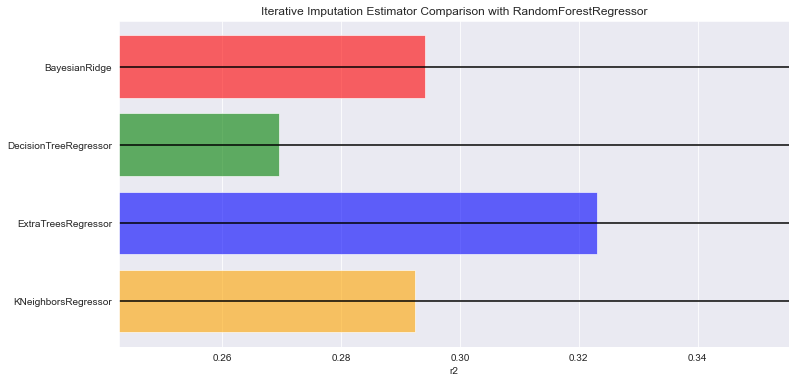

In [620]:
ax1, ax2 = compare_imputer_scores(X, y, regressor, 'r2', estimators)

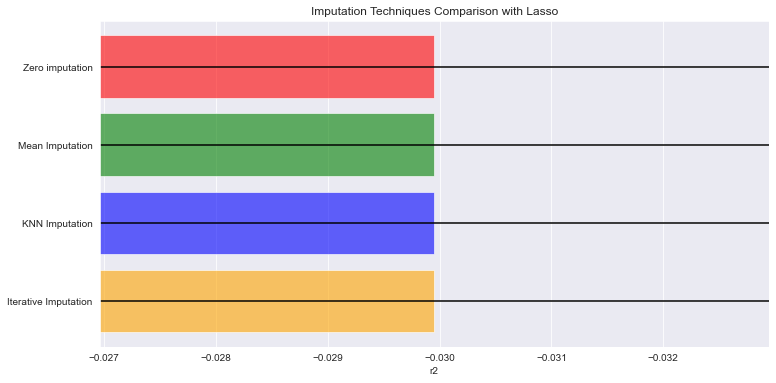

In [621]:
x1.figure

We can see that the DecisionTreeRegressor has suffered due to the change in max_features KNeighborsRegressor has done better using 5 neighbors rather than 15.

Let's change some hyperparameters again and see how things differ

In [622]:
estimators = [
    BayesianRidge(),
    DecisionTreeRegressor(max_features='log2', random_state=0),
    ExtraTreesRegressor(n_estimators=20, max_features='sqrt', random_state=0),
    KNeighborsRegressor(n_neighbors=30)
]

Imputing with IterativeImputer using BayesianRidge estimator
Imputing with IterativeImputer using DecisionTreeRegressor estimator


/Users/igorlimarochaazevedo/Documents/Documents_IgorsMacBookPro/UnB/TCC/MLFA/MLFA_VENV/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning:

[IterativeImputer] Early stopping criterion not reached.

/Users/igorlimarochaazevedo/Documents/Documents_IgorsMacBookPro/UnB/TCC/MLFA/MLFA_VENV/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning:

[IterativeImputer] Early stopping criterion not reached.

/Users/igorlimarochaazevedo/Documents/Documents_IgorsMacBookPro/UnB/TCC/MLFA/MLFA_VENV/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning:

[IterativeImputer] Early stopping criterion not reached.

/Users/igorlimarochaazevedo/Documents/Documents_IgorsMacBookPro/UnB/TCC/MLFA/MLFA_VENV/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning:

[IterativeImputer] Early stopping criterion not reached.



Imputing with IterativeImputer using ExtraTreesRegressor estimator


/Users/igorlimarochaazevedo/Documents/Documents_IgorsMacBookPro/UnB/TCC/MLFA/MLFA_VENV/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning:

[IterativeImputer] Early stopping criterion not reached.

/Users/igorlimarochaazevedo/Documents/Documents_IgorsMacBookPro/UnB/TCC/MLFA/MLFA_VENV/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning:

[IterativeImputer] Early stopping criterion not reached.

/Users/igorlimarochaazevedo/Documents/Documents_IgorsMacBookPro/UnB/TCC/MLFA/MLFA_VENV/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning:

[IterativeImputer] Early stopping criterion not reached.

/Users/igorlimarochaazevedo/Documents/Documents_IgorsMacBookPro/UnB/TCC/MLFA/MLFA_VENV/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning:

[IterativeImputer] Early stopping criterion not reached.

/Users/igorlimarochaazevedo/Documents/Documents_IgorsMacBookPro/UnB/TCC/MLFA/MLFA_VENV/l

Imputing with IterativeImputer using KNeighborsRegressor estimator


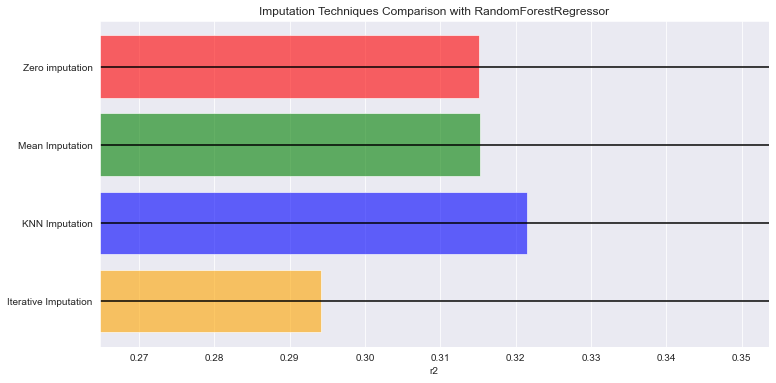

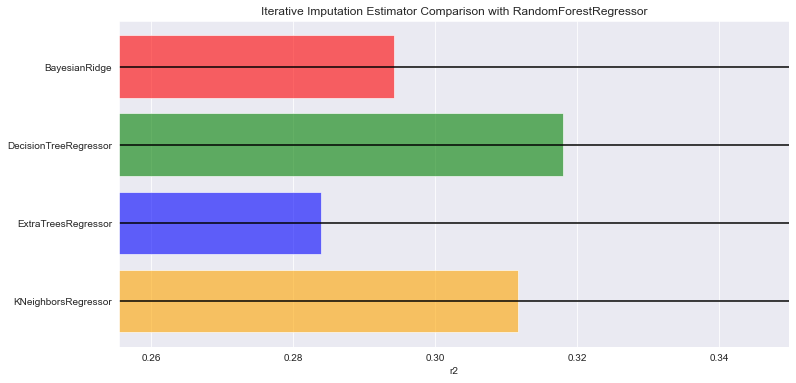

In [623]:
ax1, ax2 = compare_imputer_scores(X,
                                  y,
                                  regressor,
                                  scoring='r2',
                                  iterative_estimators=estimators
                                  )


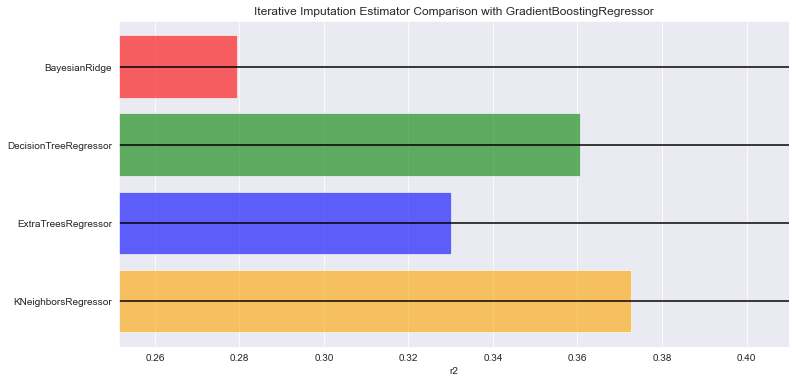

In [514]:
ax2.figure

#### XGBRegressor

In [624]:
regressor = XGBRegressor(objective='reg:squarederror')

In [625]:
estimators = [
    BayesianRidge(),
    DecisionTreeRegressor(max_features='auto', random_state=0),
    ExtraTreesRegressor(n_estimators=10, max_features='auto', random_state=0),
    KNeighborsRegressor(n_neighbors=5)
]

Imputing with IterativeImputer using BayesianRidge estimator
Imputing with IterativeImputer using DecisionTreeRegressor estimator


/Users/igorlimarochaazevedo/Documents/Documents_IgorsMacBookPro/UnB/TCC/MLFA/MLFA_VENV/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning:

[IterativeImputer] Early stopping criterion not reached.

/Users/igorlimarochaazevedo/Documents/Documents_IgorsMacBookPro/UnB/TCC/MLFA/MLFA_VENV/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning:

[IterativeImputer] Early stopping criterion not reached.

/Users/igorlimarochaazevedo/Documents/Documents_IgorsMacBookPro/UnB/TCC/MLFA/MLFA_VENV/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning:

[IterativeImputer] Early stopping criterion not reached.

/Users/igorlimarochaazevedo/Documents/Documents_IgorsMacBookPro/UnB/TCC/MLFA/MLFA_VENV/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning:

[IterativeImputer] Early stopping criterion not reached.



Imputing with IterativeImputer using ExtraTreesRegressor estimator


/Users/igorlimarochaazevedo/Documents/Documents_IgorsMacBookPro/UnB/TCC/MLFA/MLFA_VENV/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning:

[IterativeImputer] Early stopping criterion not reached.

/Users/igorlimarochaazevedo/Documents/Documents_IgorsMacBookPro/UnB/TCC/MLFA/MLFA_VENV/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning:

[IterativeImputer] Early stopping criterion not reached.

/Users/igorlimarochaazevedo/Documents/Documents_IgorsMacBookPro/UnB/TCC/MLFA/MLFA_VENV/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning:

[IterativeImputer] Early stopping criterion not reached.

/Users/igorlimarochaazevedo/Documents/Documents_IgorsMacBookPro/UnB/TCC/MLFA/MLFA_VENV/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning:

[IterativeImputer] Early stopping criterion not reached.

/Users/igorlimarochaazevedo/Documents/Documents_IgorsMacBookPro/UnB/TCC/MLFA/MLFA_VENV/l

Imputing with IterativeImputer using KNeighborsRegressor estimator


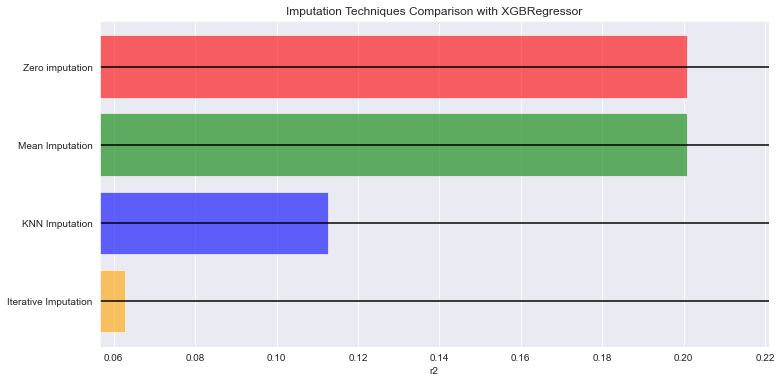

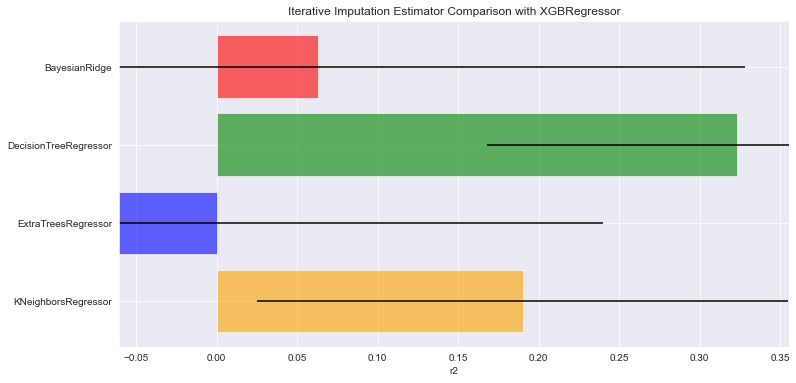

In [626]:
ax1, ax2 = compare_imputer_scores(X,
                                  y,
                                  regressor,
                                  scoring='r2',
                                  iterative_estimators=estimators
                                  )


In [627]:
regressor = XGBRFRegressor(objective='reg:squarederror')

Imputing with IterativeImputer using BayesianRidge estimator
Imputing with IterativeImputer using DecisionTreeRegressor estimator


/Users/igorlimarochaazevedo/Documents/Documents_IgorsMacBookPro/UnB/TCC/MLFA/MLFA_VENV/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning:

[IterativeImputer] Early stopping criterion not reached.

/Users/igorlimarochaazevedo/Documents/Documents_IgorsMacBookPro/UnB/TCC/MLFA/MLFA_VENV/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning:

[IterativeImputer] Early stopping criterion not reached.

/Users/igorlimarochaazevedo/Documents/Documents_IgorsMacBookPro/UnB/TCC/MLFA/MLFA_VENV/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning:

[IterativeImputer] Early stopping criterion not reached.

/Users/igorlimarochaazevedo/Documents/Documents_IgorsMacBookPro/UnB/TCC/MLFA/MLFA_VENV/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning:

[IterativeImputer] Early stopping criterion not reached.



Imputing with IterativeImputer using ExtraTreesRegressor estimator


/Users/igorlimarochaazevedo/Documents/Documents_IgorsMacBookPro/UnB/TCC/MLFA/MLFA_VENV/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning:

[IterativeImputer] Early stopping criterion not reached.

/Users/igorlimarochaazevedo/Documents/Documents_IgorsMacBookPro/UnB/TCC/MLFA/MLFA_VENV/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning:

[IterativeImputer] Early stopping criterion not reached.

/Users/igorlimarochaazevedo/Documents/Documents_IgorsMacBookPro/UnB/TCC/MLFA/MLFA_VENV/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning:

[IterativeImputer] Early stopping criterion not reached.

/Users/igorlimarochaazevedo/Documents/Documents_IgorsMacBookPro/UnB/TCC/MLFA/MLFA_VENV/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning:

[IterativeImputer] Early stopping criterion not reached.

/Users/igorlimarochaazevedo/Documents/Documents_IgorsMacBookPro/UnB/TCC/MLFA/MLFA_VENV/l

Imputing with IterativeImputer using KNeighborsRegressor estimator


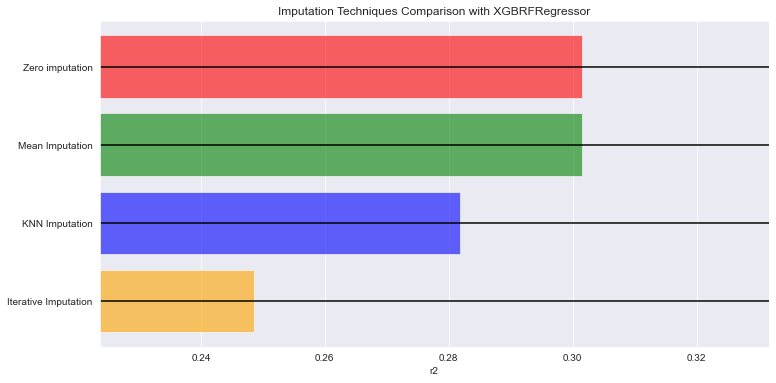

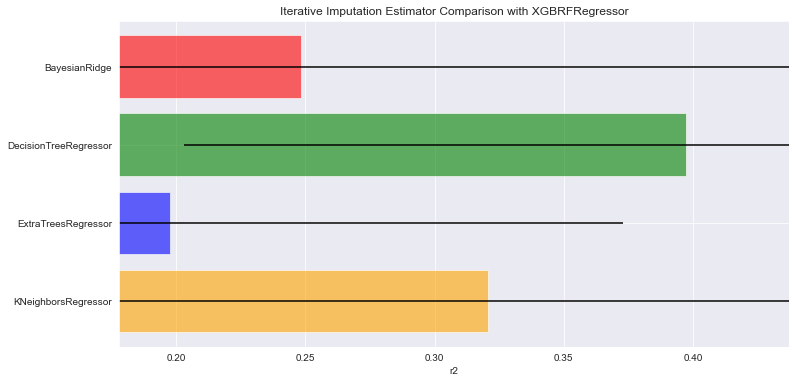

In [628]:
ax1, ax2 = compare_imputer_scores(X,
                                  y,
                                  regressor,
                                  scoring='r2',
                                  iterative_estimators=estimators
                                  )


## Modeling the data

Now that we have evaluated methods of imputing missing data, it is time to model the prices using our features.

First, let's test some simple models in order to practice our knowledge 

In [564]:
imputer_estimator = KNeighborsRegressor(weights='distance', n_jobs=-1)
#n_nearest_features = None
sample_posterior = True

scaler = StandardScaler()

imputer = IterativeImputer(estimator=imputer_estimator,
                           missing_values=np.nan, 
                           add_indicator=True,
                           random_state=123,
                           #sample_posterior=sample_posterior
                          )

regressor = RandomForestRegressor(random_state=0, n_jobs=-1)

steps = [('scaler', scaler),
         ('imputer', imputer),
         ('regressor', regressor)
        ]
estimator = Pipeline(steps=steps)

param_grid = {'imputer__n_nearest_features': [10, 15, 20],
              #'imputer__weights': ['uniform', 'auto'],
              #'regressor__loss': ['ls', 'lad', 'huber'],
              'regressor__n_estimators': [10, 50, 100, 200],
              'regressor__max_features': ['auto', 'sqrt', 'log2'],
              'regressor__min_samples_leaf': [1, 2, 5]
             }

grid_search = GridSearchCV(estimator, param_grid=param_grid, scoring='r2', cv=5)
grid_fit = grid_search.fit(X, y)

/Users/igorlimarochaazevedo/Documents/Documents_IgorsMacBookPro/UnB/TCC/MLFA/MLFA_VENV/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning:

[IterativeImputer] Early stopping criterion not reached.

/Users/igorlimarochaazevedo/Documents/Documents_IgorsMacBookPro/UnB/TCC/MLFA/MLFA_VENV/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning:

[IterativeImputer] Early stopping criterion not reached.

/Users/igorlimarochaazevedo/Documents/Documents_IgorsMacBookPro/UnB/TCC/MLFA/MLFA_VENV/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning:

[IterativeImputer] Early stopping criterion not reached.

/Users/igorlimarochaazevedo/Documents/Documents_IgorsMacBookPro/UnB/TCC/MLFA/MLFA_VENV/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning:

[IterativeImputer] Early stopping criterion not reached.

/Users/igorlimarochaazevedo/Documents/Documents_IgorsMacBookPro/UnB/TCC/MLFA/MLFA_VENV/l

In [521]:
print('Best Model: \n r-squared:', grid_fit.best_score_)
grid_fit.best_params_

Best Model: 
 r-squared: 0.43436072253850755


{'imputer__n_neighbors': 30,
 'regressor__learning_rate': 0.01,
 'regressor__max_depth': 5,
 'regressor__n_estimators': 1000,
 'regressor__subsample': 1.0}

In [522]:
grid_fit.best_score_

0.43436072253850755

Text(0.5, 1.0, 'Distribution of Log Returns in IBOVESPA simulated by ML from 2018-10-08 - 2021-12-08')

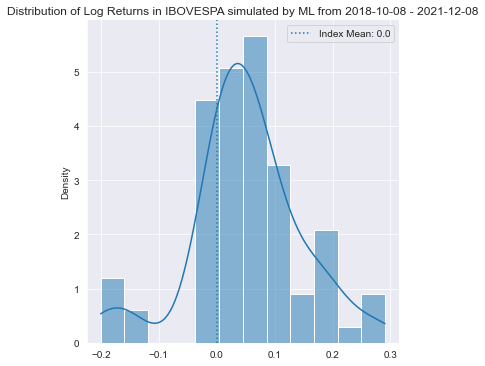

In [525]:
# This looks good, after a long time we have our optimal parameters and a good r2 of .87
# The whole idea in generating this model was to use the residuals from it to see if they have
# a relationship with the actual returns, hopefully a nice linear relationship, let's generate
# residuals and have a look

preds = grid_fit.best_estimator_.predict(X)
resids = y - preds
sns.displot(preds, kde=True, stat="density")
plt.axvline(resids.mean(), ls=':',
            label='Index Mean: {}'.format(round(resids.mean(), 2)))
plt.legend()
plt.title(
    'Distribution of Log Returns in IBOVESPA simulated by ML from {} - {}'.format(start_date, end_date))


Let's look again at our log returns over the period of study

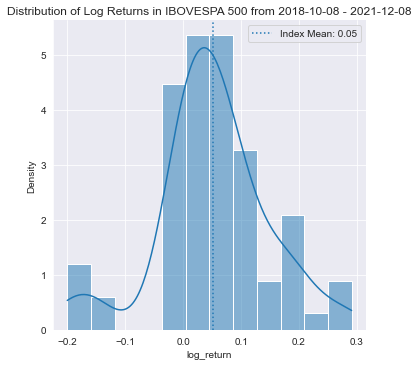

In [ ]:
plot_log_return(ibovespa_close_hist, start_date, end_date)

We would have been hoping to see a negative linear relationship here, since higher residual values would correspond possibly to overvalued securities, as their current trading price would have been higher than what the model figured. The range of the residuals is very narrow, so right now I'm not seeing the kind of relation I was hoping for. Let's run a linreg anyways and see what we get

In [526]:
test_df = pd.DataFrame(zip(resids, y))
test_df.columns = ['resids', 'log_returns']
test_df.head()

,resids,log_returns
0,-0.000241,-0.004327
1,0.000155,0.171360
2,-0.000099,-0.008351
3,-0.000019,-0.009475
4,-0.000202,0.063952


In [529]:


feature_importance = grid_fit.steps[2][1].feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(8, 14))
plt.subplot(1, 1, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(X.columns)[sorted_idx])
plt.title('Feature Importance (MDI)')



AttributeError: 'GridSearchCV' object has no attribute 'steps'